# **Company Bankruptcy Prediction**

In [11]:
# IMPORTING LIBRARIES
import matplotlib.pyplot as plt
from functools import *
import itertools
from itertools import combinations
import datetime
import pytz
import operator
import seaborn as sns
import pandas as pd
import numpy as np
np.set_printoptions(formatter = {'float': '{: 0.1f}'.format})
from scipy import stats
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import files
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve
import xgboost
from sklearn.metrics import roc_curve
from xgboost import plot_importance
from sklearn.feature_selection import VarianceThreshold

In [12]:
# IMPORTING DATA
# Source: https://www.kaggle.com/fedesoriano/company-bankruptcy-prediction
file_name = 'data.csv'
uploaded = files.upload()

Saving data.csv to data (1).csv


In [13]:
dataset = pd.read_csv(file_name, delimiter=',')

## Exploratory Data Analysis

### Data Analysis

In [ ]:
dataset.shape

(6819, 96)

In [ ]:
dataset.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,...,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,Bankrupt?
0,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256970e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,...,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469,1
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897850e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,...,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065200e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794,1
2,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361300e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.368913,0.011543,0.005348,0.629631,0.021248,0.207516,0.792484,0.005100,0.379093,..

In [ ]:
# Exploring the dataset
print("Number of rows: %s" % dataset.shape[0])
print("Number of columns: %s" % dataset.shape[1])
dataset.info()

Number of rows: 6819
Number of columns: 96
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 1    ROA(A) before interest and % after tax                   6819 non-null   float64
 2    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 3    Operating Gross Margin                                   6819 non-null   float64
 4    Realized Sales Gross Margin                              6819 non-null   float64
 5    Operating Profit Rate                                    6819 non-null   float64
 6    Pre-tax net Interest Rate                                6819 non-null   float64
 7    After-tax net Interest Rate                              6819

In [ ]:
# Computing the descriptive statistics of our numrerical features
dataset.describe()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,...,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,Bankrupt?
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000,6819.000000
mean,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.115001,0.190661,0.190633,0.190672,0.228813,0.323482,1.328641e+06,0.109091,0.184361,0.022408,0.847980,0.689146,0.689150,0.217639,5.508097e+09,1.566212e+06,0.264248,0.379677,4.032850e+05,8.376595e+06,0.630991,4.416337e+06,0.113177,0.886823,0.008783,0.374654,...,0.124095,3.592902e+06,3.715999e+07,0.090673,0.353828,0.277395,5.580680e+07,0.761599,0.735817,0.331410,5.416004e+07,0.934733,0.002549,0.029184,1.195856e+09,2.163735e+09,0.594006,2.471977e+09,0.671531,1.220121e+06,0.761599,0.331410,0.115645,0.649731,0.461849,0.593415,0.315582,0.031506,0.001173,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578,0.032263
std,0.060686,0.065620,0.0615

In [ ]:
# Check if dataset free from null values
print('')
dataset.isnull().sum()

 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
 Realized Sales Gross Margin                                0
                                                           ..
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Bankrupt?                                                   0
Length: 96, dtype: int64

In [ ]:
# Checking Nan 

dataset.isna().sum().max()
[print(col) for col in dataset if dataset[col].isna().sum() > 0]

[]

In [ ]:
# Check duplicates 
dataset.duplicated().sum()

0

In [ ]:
# check bankrupt column is 0 or 1
dataset['Bankrupt?'].unique()

array([1, 0])

### Data Visualization

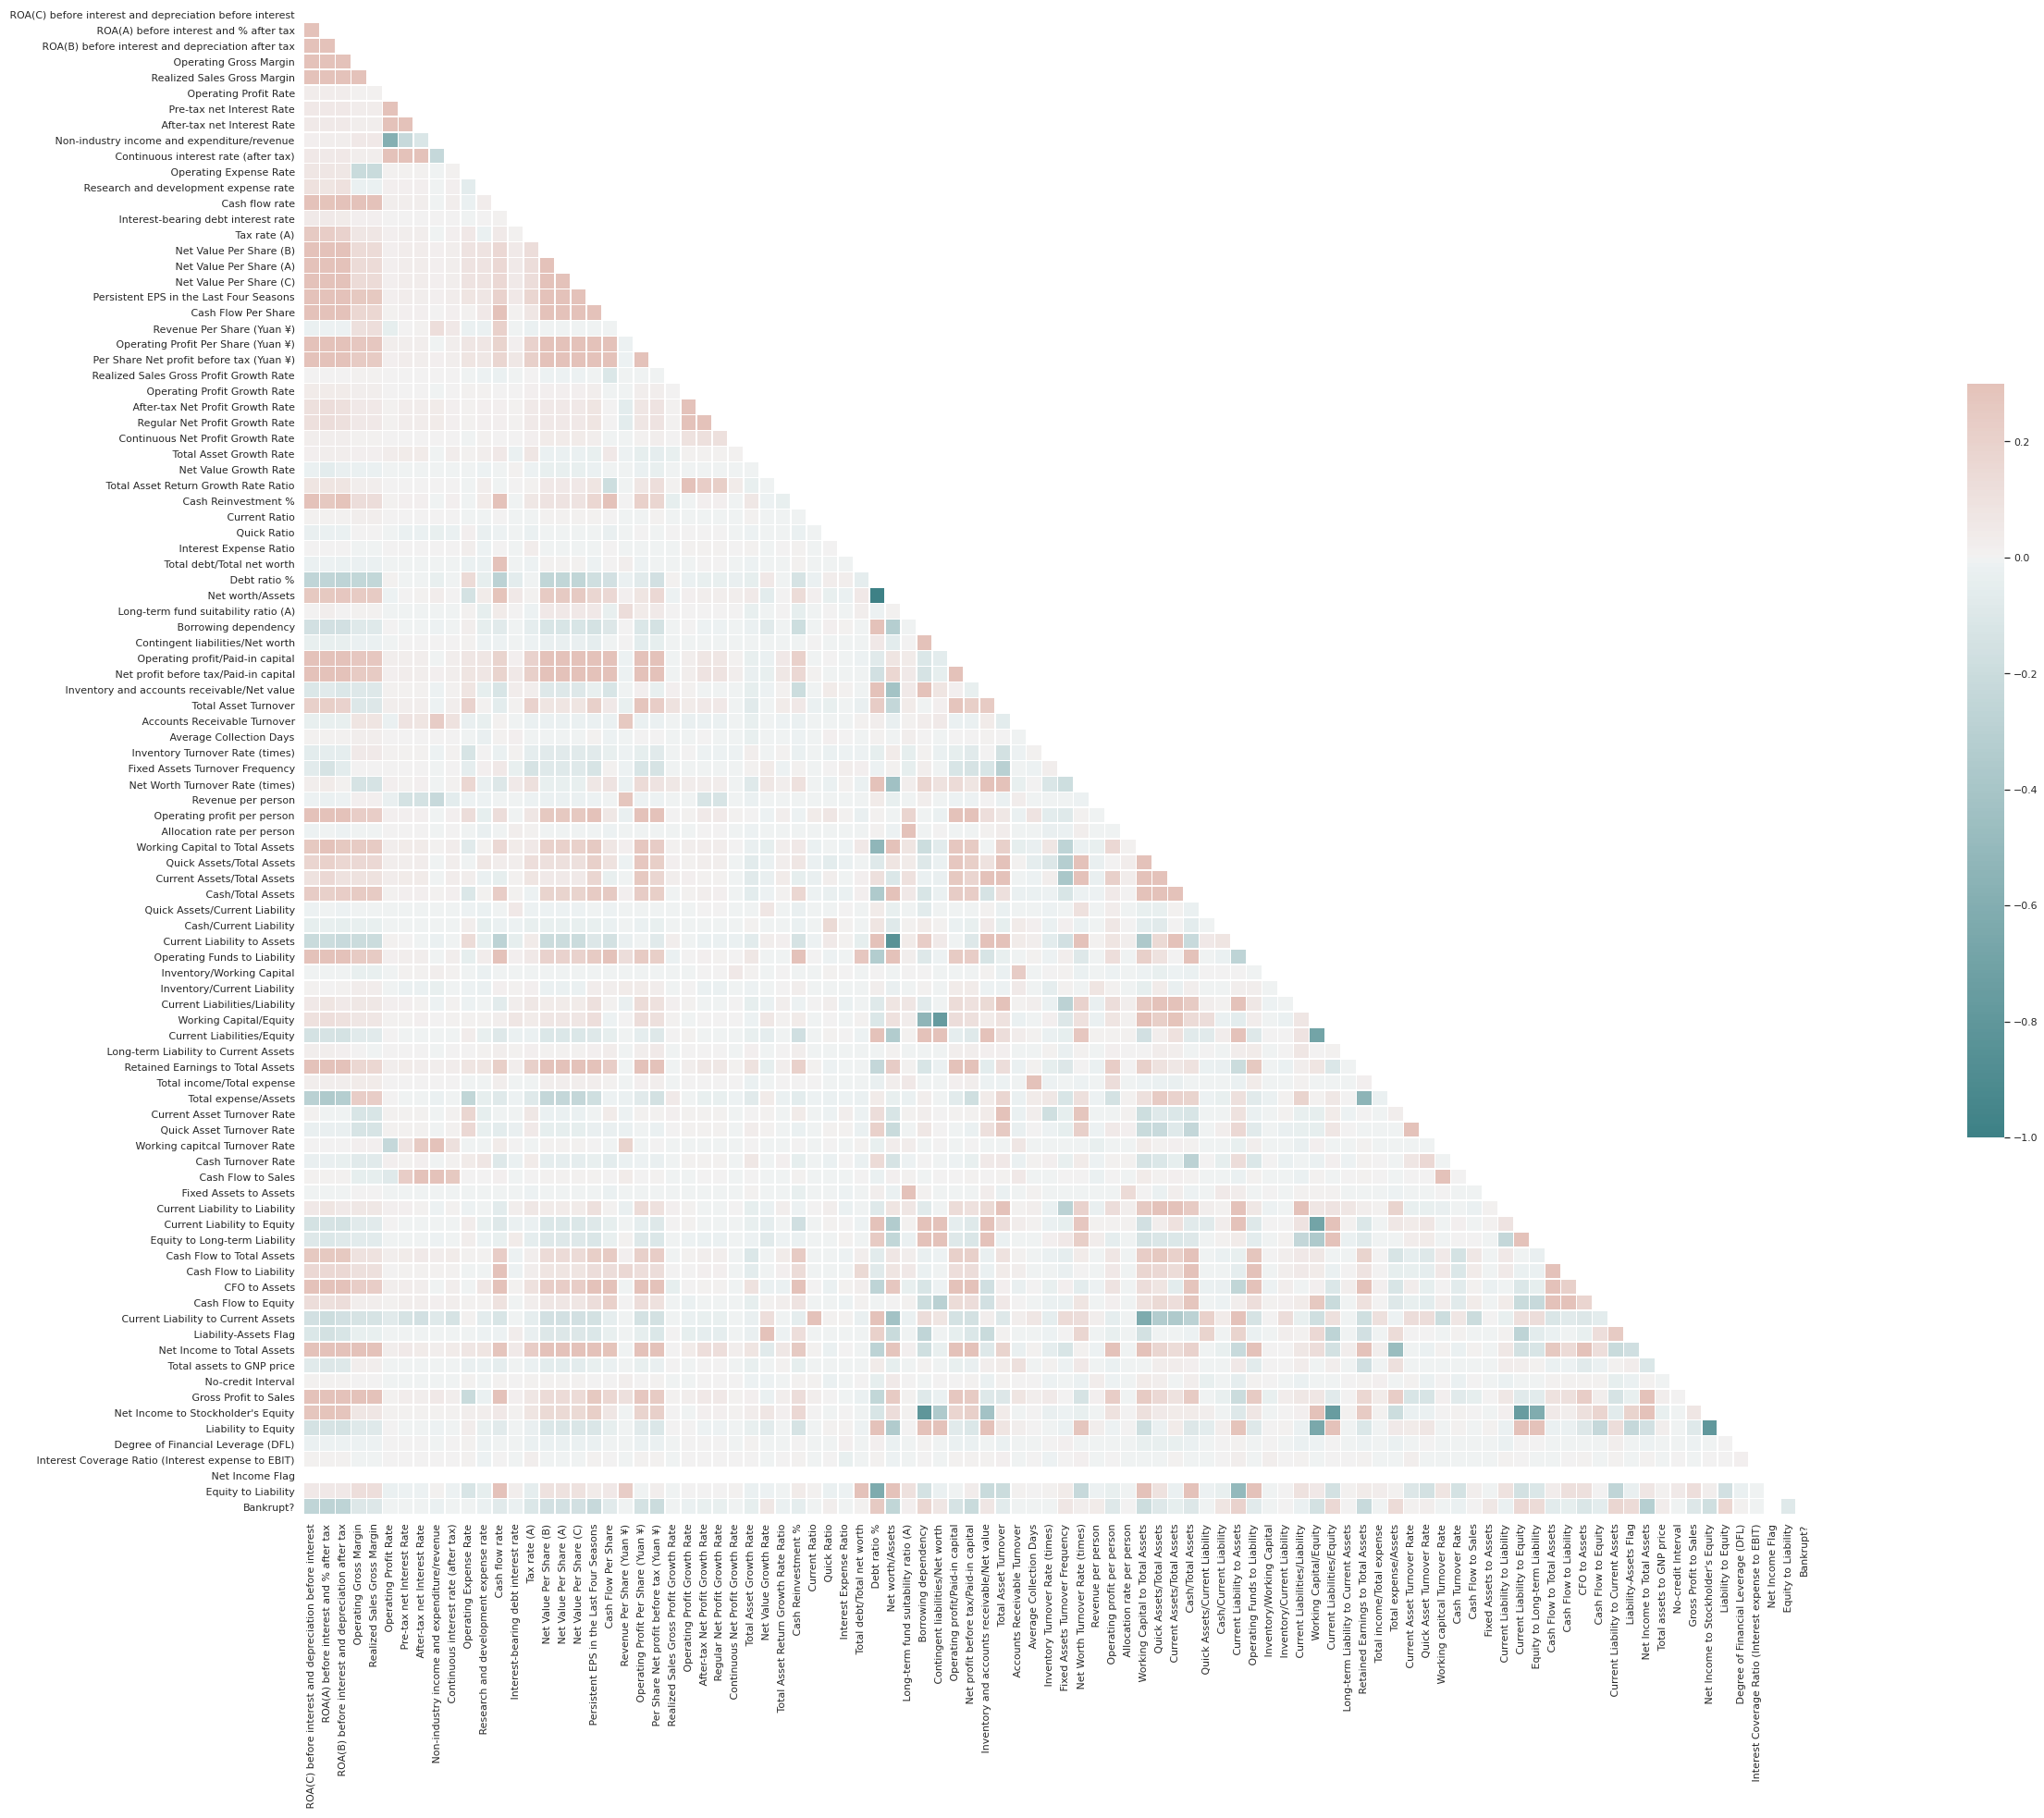

In [ ]:
# Correlation between fields

sns.set_theme(style="white")
corr=dataset.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(60, 30))
cmap = sns.diverging_palette(200, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

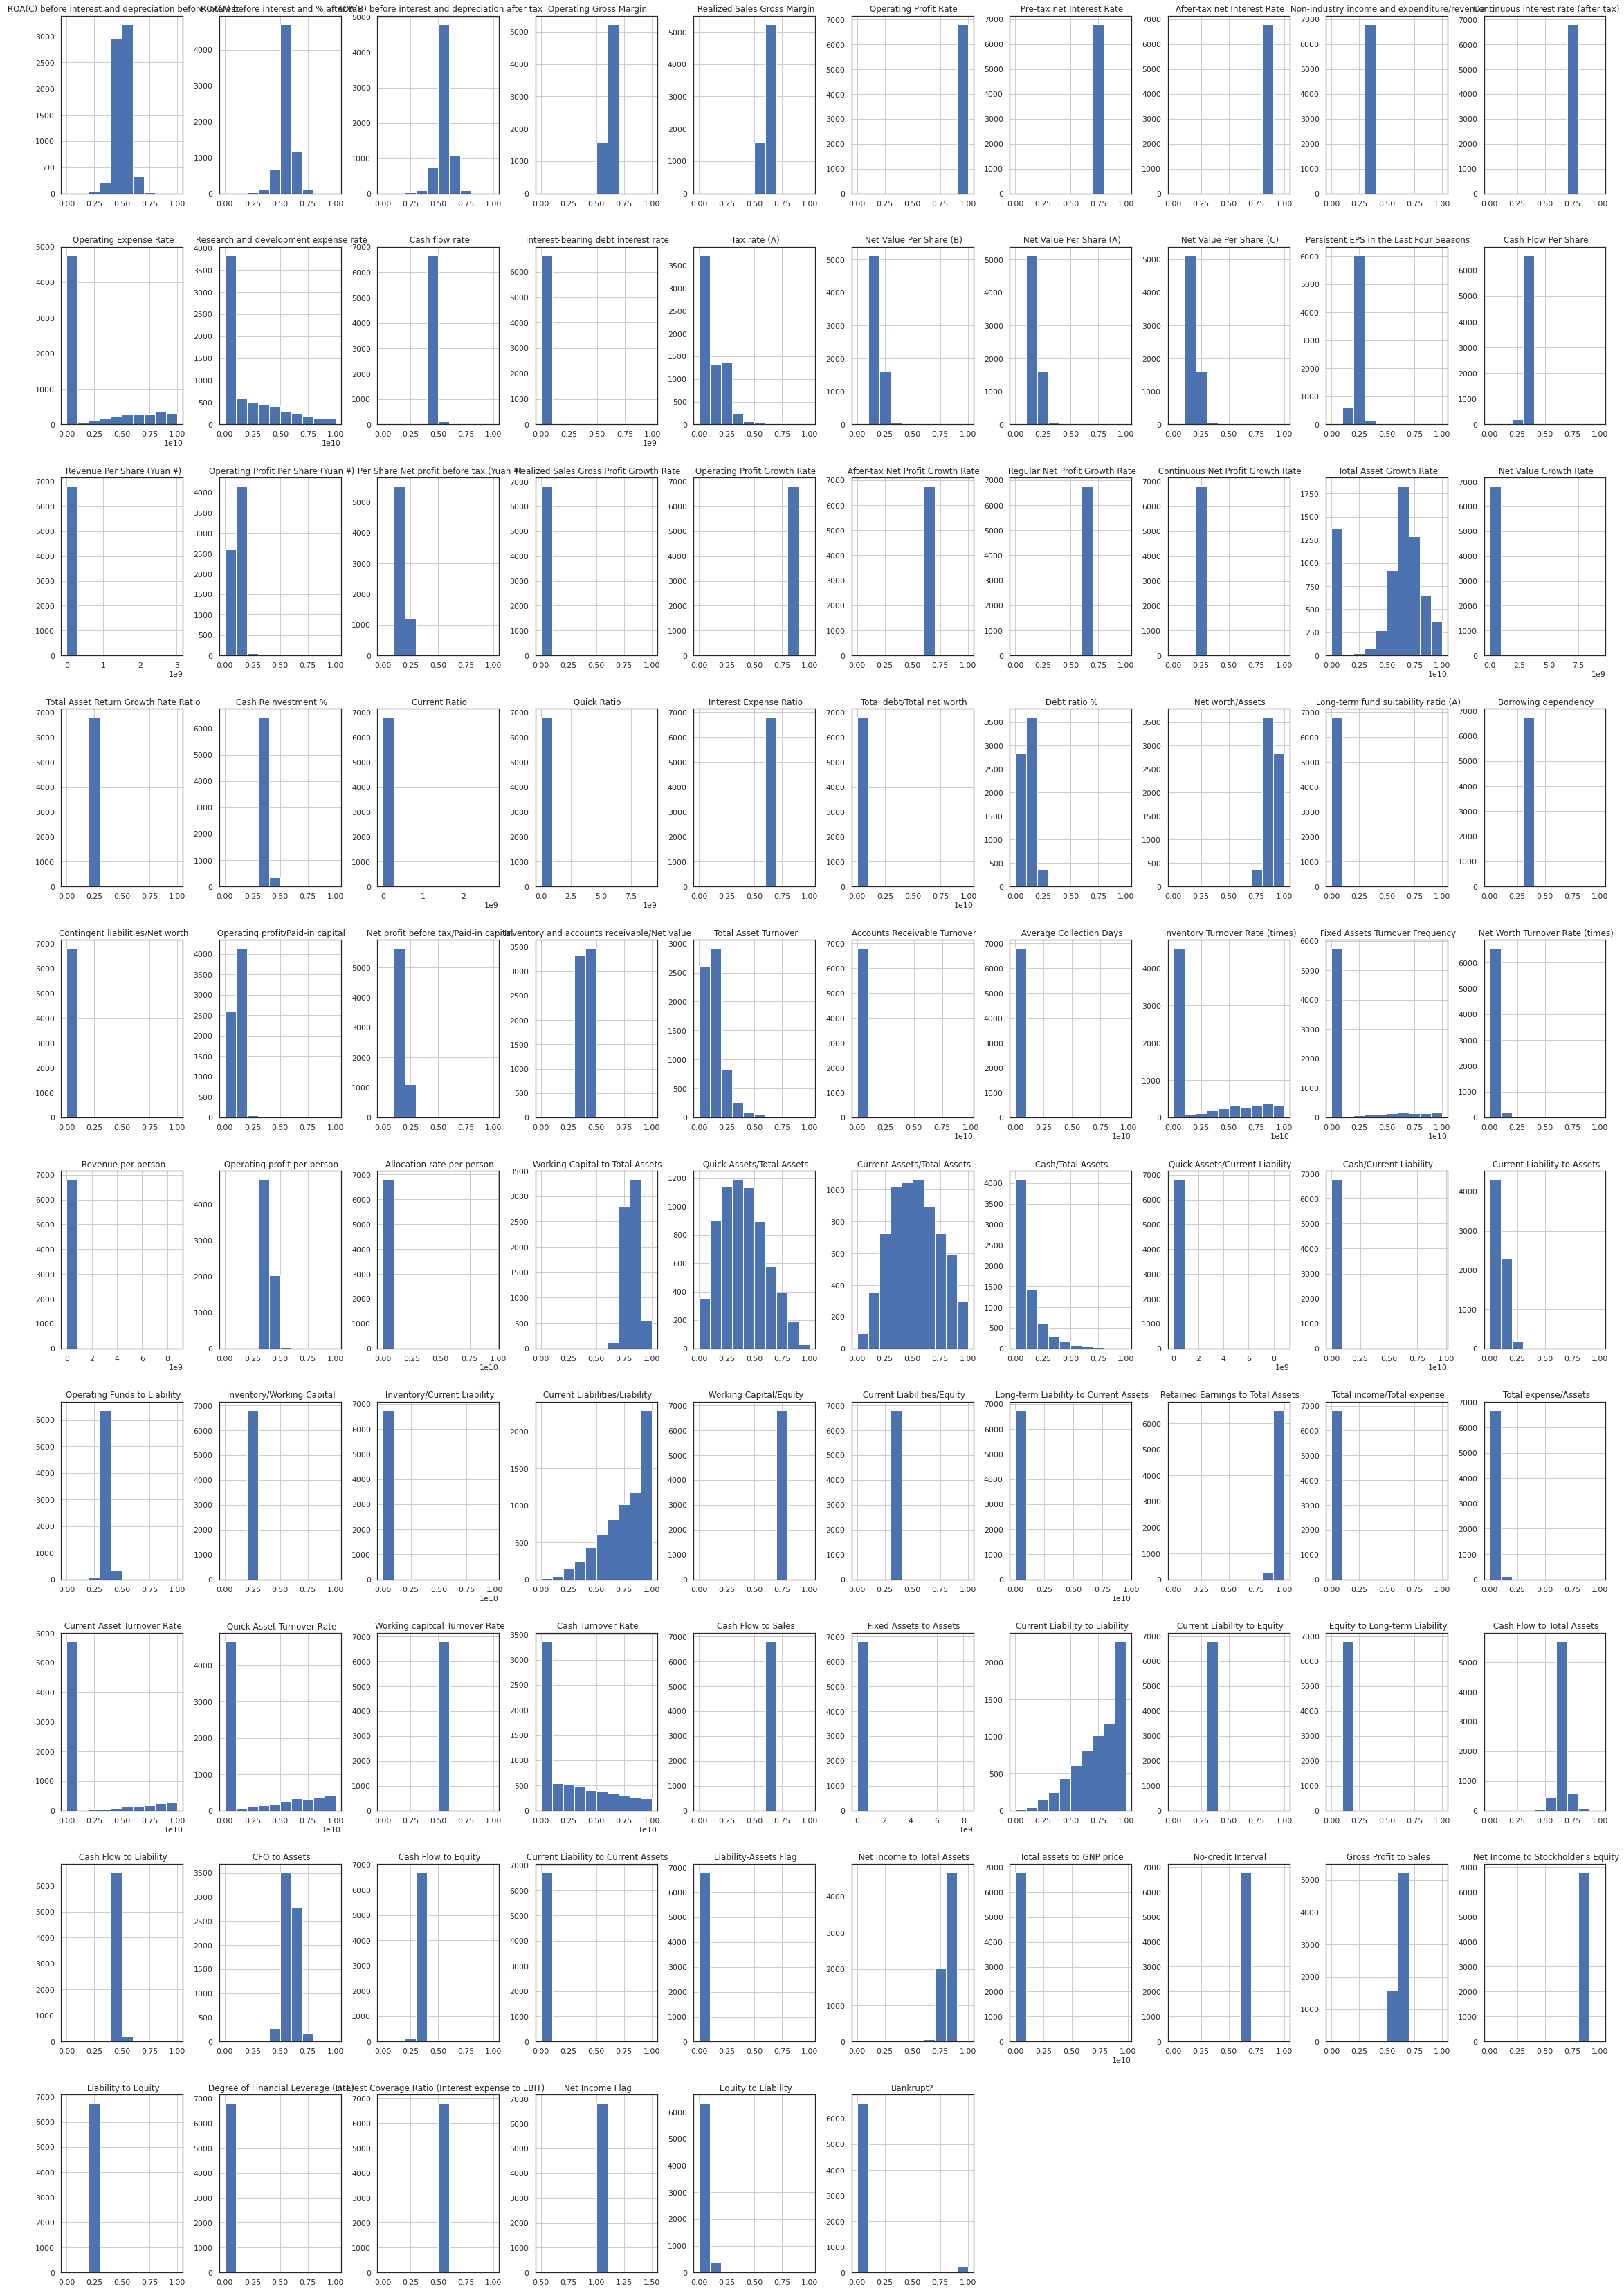

In [ ]:
# plot the distributions of each input features
dataset.hist(figsize=(40,60))
plt.show()

### Distribution of the Output Labels

In [ ]:
# Checking labels distributions
print(dataset['Bankrupt?'].value_counts())
print('-'* 30)
print( round(dataset['Bankrupt?'].value_counts()[0]/len(dataset) * 100,2), )
print( round(dataset['Bankrupt?'].value_counts()[1]/len(dataset) * 100,2), )

0    6599
1     220
Name: Bankrupt?, dtype: int64
------------------------------
96.77
3.23


The dataset is very imbalanced, so the baseline accuracy should be high.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


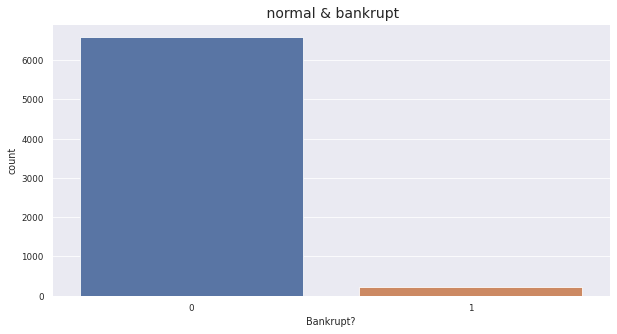

In [ ]:
# Checking labels distributions

sns.set_theme(context = 'paper')

plt.figure(figsize = (10,5))
sns.countplot(dataset['Bankrupt?'])
plt.title(' normal & bankrupt', fontsize=14)
plt.show()

### Split and Normalization 


In [ ]:
# Convert to Numpy Array
dataset_np = dataset.values
X = dataset.drop('Bankrupt?', axis='columns').values
Y = dataset['Bankrupt?'].values

In [ ]:
# Data standardizatin
# Standardization
# mean = X.mean(axis = 0)
# std = X.std(axis = 0)
# X -= mean
# X /= std
# use the method provide in kklearn instead of this 

scaler = preprocessing.StandardScaler().fit(dataset)
X = scaler.transform(dataset)

In [ ]:
# Split and shuffle the dataset
XTRAIN, XVALID, YTRAIN, YVALID = train_test_split(X, Y, test_size = 0.2, random_state = 1)

## Model

### Univariate linear regression

In [ ]:
# univariate linear regression
callback_b = EarlyStopping(monitor = 'val_loss', mode = 'auto' , patience = 50, verbose = 1)

modelL = Sequential()
modelL.add(Dense(1, input_dim = len(XTRAIN[0, :]), activation='linear'))
modelL.compile(loss='mse', optimizer = 'rmsprop', metrics=['mse'])


In [ ]:
historyL = modelL.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs = 128, batch_size=128, verbose = 1, callbacks = [ callback_b])

Epoch 1/128
43/43 [==============================] - 1s 6ms/step - loss: 1.2638 - mse: 1.2638 - val_loss: 2.1731 - val_mse: 2.1731
Epoch 2/128
43/43 [==============================] - 0s 2ms/step - loss: 1.2607 - mse: 1.2607 - val_loss: 1.8450 - val_mse: 1.8450
Epoch 3/128
43/43 [==============================] - 0s 2ms/step - loss: 0.6339 - mse: 0.6339 - val_loss: 1.6537 - val_mse: 1.6537
Epoch 4/128
43/43 [==============================] - 0s 2ms/step - loss: 0.5194 - mse: 0.5194 - val_loss: 1.5422 - val_mse: 1.5422
Epoch 5/128
43/43 [==============================] - 0s 2ms/step - loss: 0.4586 - mse: 0.4586 - val_loss: 1.4399 - val_mse: 1.4399
Epoch 6/128
43/43 [==============================] - 0s 2ms/step - loss: 0.3663 - mse: 0.3663 - val_loss: 1.3943 - val_mse: 1.3943
Epoch 7/128
43/43 [==============================] - 0s 2ms/step - loss: 0.2790 - mse: 0.2790 - val_loss: 1.3649 - val_mse: 1.3649
Epoch 8/128
43/43 [==============================] - 0s 2ms/step - loss: 0.2689 - m

In [ ]:
PLinT = modelL.predict(XTRAIN)
PLinV = modelL.predict(XVALID)
errorPT = PLinT - YTRAIN
errorPV = PLinV - YVALID
print("Training MSE: " + str(np.square(errorPT).mean()))
print("Validation MSE: " + str(np.square(errorPV).mean()))

Training MSE: 0.0593573789452013
Validation MSE: 0.5220066653073986


In [ ]:
scores = modelL.evaluate(XVALID, YVALID)
ypred = modelL.predict(XVALID)
ypred = (ypred > 0.5)
cm = confusion_matrix(YVALID, ypred)
acc = (cm[0, 0] + cm[1, 1]) / sum(cm.flatten()) * 100
print("\n%s" % cm)
print("%s%%\n" % acc)




accuracy = accuracy_score(YVALID, ypred.round()) * 100.0
precision = precision_score(YVALID, ypred.round()) * 100.0
recall = recall_score(YVALID, ypred.round()) * 100.0
f1score = f1_score(YVALID, ypred.round())

print("Accuracy: %.2f%%" % (accuracy))
print("Precision: %.2f%%" % (precision))
print("Recall: %.2f%%" % (recall))
print("F1-score: %.2f\n" % (f1score))

43/43 [==============================] - 0s 971us/step - loss: 0.4564 - mse: 0.4564

[[1312    2]
 [   1   49]]
99.7800586510264%

Accuracy: 99.78%
Precision: 96.08%
Recall: 98.00%
F1-score: 0.97



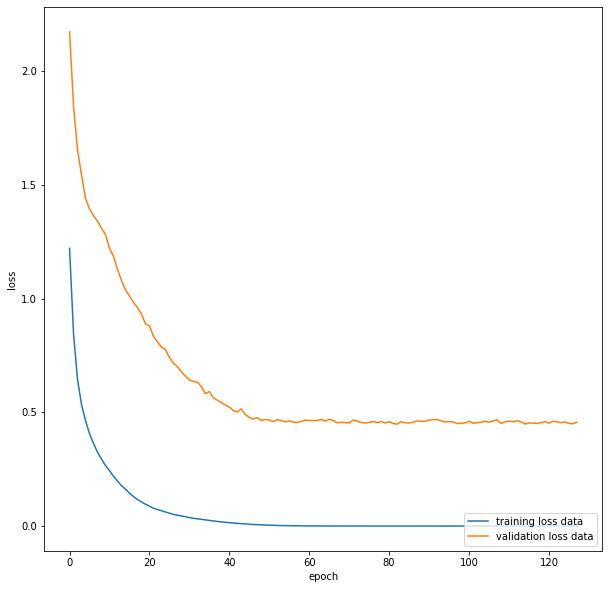

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(historyL.history['loss']) 
plt.plot(historyL.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss data', 'validation loss data'], loc='lower right')
plt.show()

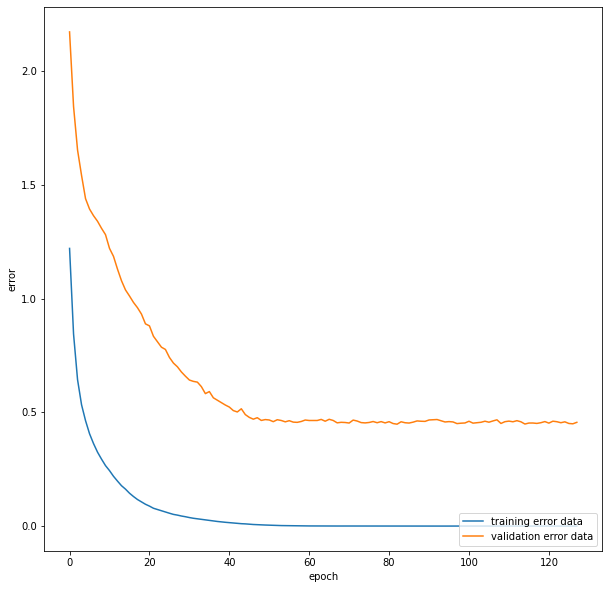

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(historyL.history['mse']) 
plt.plot(historyL.history['val_mse']) 
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['training error data', 'validation error data'], loc='lower right')
plt.show()

### Logistic regression

In [ ]:
# sigmoid activation for all neurons
callback_b = EarlyStopping(monitor = 'val_loss', mode = 'auto' , patience = 50, verbose = 1)

modelS = Sequential()
modelS.add(Dense(1, input_dim = len(XTRAIN[0, :]), activation='sigmoid'))
modelS.compile(loss='binary_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])
historyss = modelS.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs = 512, batch_size=128, verbose = 1,callbacks = [ callback_b])

Epoch 1/512
43/43 [==============================] - 1s 5ms/step - loss: 0.7875 - accuracy: 0.4718 - val_loss: 0.7746 - val_accuracy: 0.5139
Epoch 2/512
43/43 [==============================] - 0s 2ms/step - loss: 0.7281 - accuracy: 0.5283 - val_loss: 0.7311 - val_accuracy: 0.5916
Epoch 3/512
43/43 [==============================] - 0s 3ms/step - loss: 0.6792 - accuracy: 0.6180 - val_loss: 0.6955 - val_accuracy: 0.6774
Epoch 4/512
43/43 [==============================] - 0s 2ms/step - loss: 0.6582 - accuracy: 0.7016 - val_loss: 0.6727 - val_accuracy: 0.7581
Epoch 5/512
43/43 [==============================] - 0s 3ms/step - loss: 0.6166 - accuracy: 0.7855 - val_loss: 0.6556 - val_accuracy: 0.8277
Epoch 6/512
43/43 [==============================] - 0s 3ms/step - loss: 0.5843 - accuracy: 0.8584 - val_loss: 0.6372 - val_accuracy: 0.8790
Epoch 7/512
43/43 [==============================] - 0s 3ms/step - loss: 0.5579 - accuracy: 0.9117 - val_loss: 0.6217 - val_accuracy: 0.9054
Epoch 8/512
4

In [ ]:
scores = modelS.evaluate(XVALID, YVALID)
ypred = modelS.predict(XVALID)
accuracy = accuracy_score(YVALID, ypred.round()) * 100.0
precision = precision_score(YVALID, ypred.round()) * 100.0
recall = recall_score(YVALID, ypred.round()) * 100.0
f1score = f1_score(YVALID, ypred.round())

print("Accuracy: %.2f%%" % (accuracy))
print("Precision: %.2f%%" % (precision))
print("Recall: %.2f%%" % (recall))
print("F1-score: %.2f\n" % (f1score))

43/43 [==============================] - 0s 1ms/step - loss: 0.0881 - accuracy: 0.9978
Accuracy: 99.78%
Precision: 93.02%
Recall: 100.00%
F1-score: 0.96



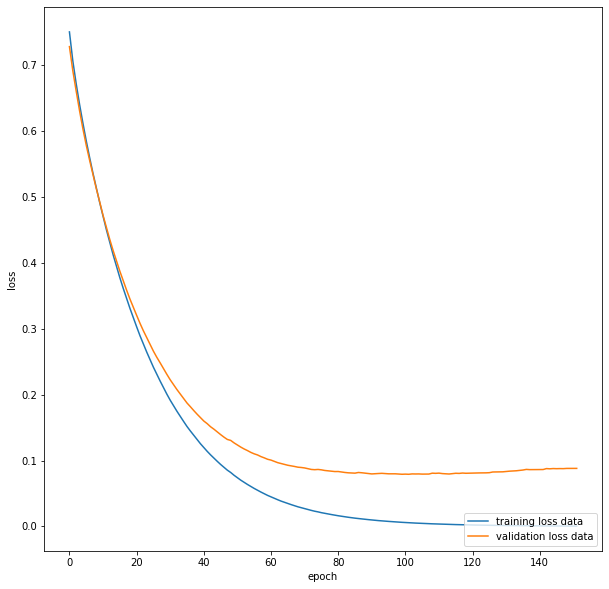

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(historyss.history['loss']) 
plt.plot(historyss.history['val_loss']) 
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss data', 'validation loss data'], loc='lower right')
plt.show()

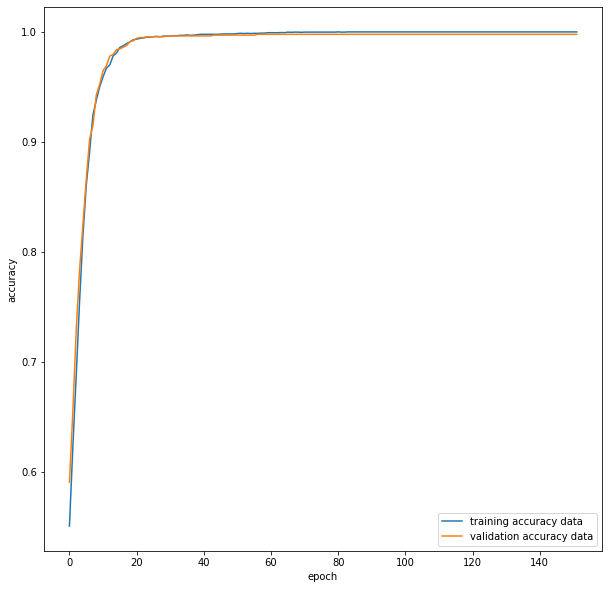

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(historyss.history['accuracy']) 
plt.plot(historyss.history['val_accuracy']) 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy data', 'validation accuracy data'], loc='lower right')
plt.show()

### Binary classification using NN

In [ ]:
# 1 layer
callback_b = EarlyStopping(monitor = 'val_loss', mode = 'auto' , patience = 50, verbose = 1)

modelN = Sequential()
modelN.add(Dense(2, input_dim = len(XTRAIN[0, :]), activation='relu'))
modelN.add(Dense(1, activation='sigmoid'))
modelN.compile(loss='binary_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])


In [ ]:
historyN = modelN.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs = 512, batch_size=128, verbose = 1, callbacks = [callback_b] )

Epoch 1/512
43/43 [==============================] - 1s 6ms/step - loss: 0.6071 - accuracy: 0.6447 - val_loss: 0.5060 - val_accuracy: 0.8026
Epoch 2/512
43/43 [==============================] - 0s 3ms/step - loss: 0.5096 - accuracy: 0.8207 - val_loss: 0.4407 - val_accuracy: 0.9252
Epoch 3/512
43/43 [==============================] - 0s 2ms/step - loss: 0.4456 - accuracy: 0.9275 - val_loss: 0.3978 - val_accuracy: 0.9618
Epoch 4/512
43/43 [==============================] - 0s 3ms/step - loss: 0.4083 - accuracy: 0.9530 - val_loss: 0.3661 - val_accuracy: 0.9663
Epoch 5/512
43/43 [==============================] - 0s 3ms/step - loss: 0.3703 - accuracy: 0.9578 - val_loss: 0.3403 - val_accuracy: 0.9685
Epoch 6/512
43/43 [==============================] - 0s 3ms/step - loss: 0.3414 - accuracy: 0.9651 - val_loss: 0.3178 - val_accuracy: 0.9692
Epoch 7/512
43/43 [==============================] - 0s 3ms/step - loss: 0.3194 - accuracy: 0.9655 - val_loss: 0.2963 - val_accuracy: 0.9751
Epoch 8/512
4

In [ ]:
scores = modelN.evaluate(XVALID, YVALID)
ypred = modelN.predict(XVALID)
accuracy = accuracy_score(YVALID, ypred.round()) * 100.0
precision = precision_score(YVALID, ypred.round()) * 100.0
recall = recall_score(YVALID, ypred.round()) * 100.0
f1score = f1_score(YVALID, ypred.round())

print("Accuracy: %.2f%%" % (accuracy))
print("Precision: %.2f%%" % (precision))
print("Recall: %.2f%%" % (recall))
print("F1-score: %.2f\n" % (f1score))

43/43 [==============================] - 0s 1ms/step - loss: 0.0185 - accuracy: 0.9978
Accuracy: 99.78%
Precision: 93.02%
Recall: 100.00%
F1-score: 0.96



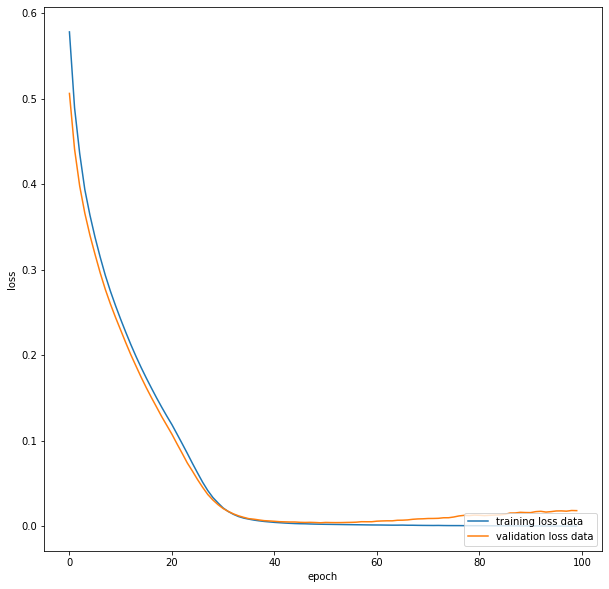

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(historyN.history['loss'])
plt.plot(historyN.history['val_loss']) 
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss data', 'validation loss data'], loc='lower right')
plt.show()

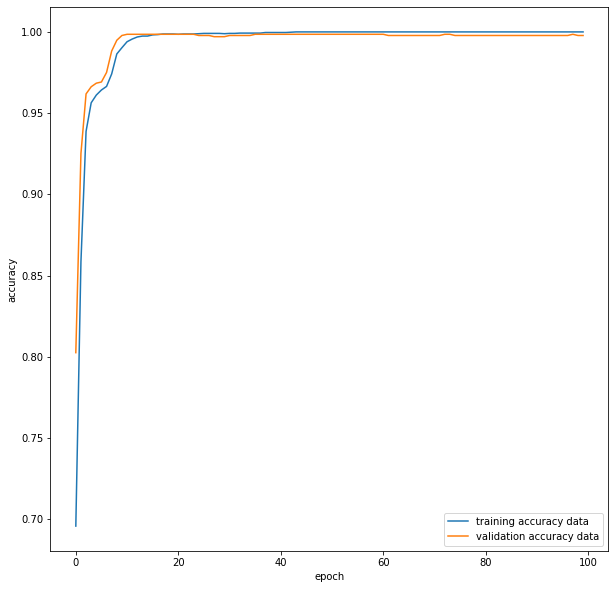

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(historyN.history['accuracy'])
plt.plot(historyN.history['val_accuracy']) 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy data', 'validation accuracy data'], loc='lower right')
plt.show()

In [ ]:
# 2 layers
callback_b = EarlyStopping(monitor = 'val_loss', mode = 'auto' , patience = 50, verbose = 1)

model1 = Sequential()
model1.add(Dense(3, input_dim = len(XTRAIN[0, :]), activation='relu'))
model1.add(Dense(2, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])
history1 = model1.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs = 512, batch_size=128, verbose = 1, callbacks = [callback_b] )

Epoch 1/512
43/43 [==============================] - 1s 6ms/step - loss: 0.6150 - accuracy: 0.9648 - val_loss: 0.5379 - val_accuracy: 0.9707
Epoch 2/512
43/43 [==============================] - 0s 3ms/step - loss: 0.5110 - accuracy: 0.9685 - val_loss: 0.4422 - val_accuracy: 0.9707
Epoch 3/512
43/43 [==============================] - 0s 3ms/step - loss: 0.4185 - accuracy: 0.9681 - val_loss: 0.3538 - val_accuracy: 0.9707
Epoch 4/512
43/43 [==============================] - 0s 3ms/step - loss: 0.3412 - accuracy: 0.9661 - val_loss: 0.2795 - val_accuracy: 0.9707
Epoch 5/512
43/43 [==============================] - 0s 3ms/step - loss: 0.2633 - accuracy: 0.9698 - val_loss: 0.2174 - val_accuracy: 0.9707
Epoch 6/512
43/43 [==============================] - 0s 3ms/step - loss: 0.2059 - accuracy: 0.9677 - val_loss: 0.1672 - val_accuracy: 0.9707
Epoch 7/512
43/43 [==============================] - 0s 2ms/step - loss: 0.1572 - accuracy: 0.9675 - val_loss: 0.1269 - val_accuracy: 0.9707
Epoch 8/512
4

In [ ]:
scores = model1.evaluate(XVALID, YVALID)
ypred = model1.predict(XVALID)
accuracy = accuracy_score(YVALID, ypred.round()) * 100.0
precision = precision_score(YVALID, ypred.round()) * 100.0
recall = recall_score(YVALID, ypred.round()) * 100.0
f1score = f1_score(YVALID, ypred.round())

print("Accuracy: %.2f%%" % (accuracy))
print("Precision: %.2f%%" % (precision))
print("Recall: %.2f%%" % (recall))
print("F1-score: %.2f\n" % (f1score))

43/43 [==============================] - 0s 1ms/step - loss: 0.0069 - accuracy: 0.9978
Accuracy: 99.78%
Precision: 95.12%
Recall: 97.50%
F1-score: 0.96



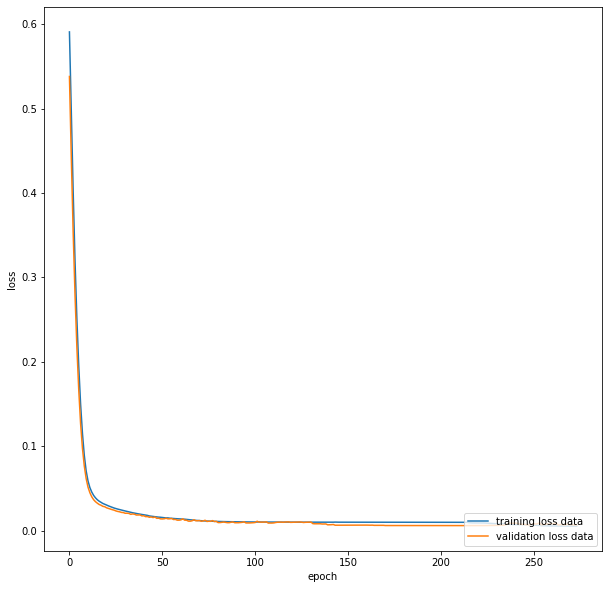

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss']) 
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss data', 'validation loss data'], loc='lower right')
plt.show()

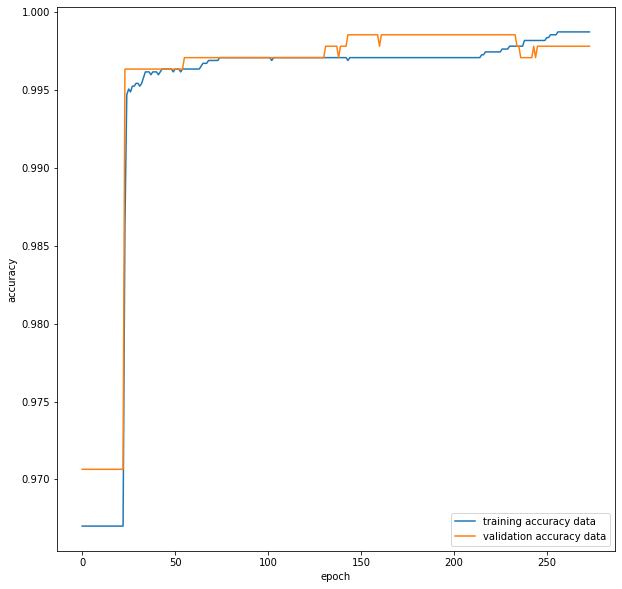

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy']) 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy data', 'validation accuracy data'], loc='lower right')
plt.show()

In [ ]:
# 3 layers(best layer)
callback_b = EarlyStopping(monitor = 'val_loss', mode = 'auto' , patience = 50, verbose = 1)

model2 = Sequential()
model2.add(Dense(4, input_dim = len(XTRAIN[0, :]), activation='relu'))
model2.add(Dense(3, activation='relu'))
model2.add(Dense(2, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])
history2 = model2.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs = 512, batch_size=128, verbose = 1, callbacks = [callback_b])

Epoch 1/512
43/43 [==============================] - 1s 6ms/step - loss: 0.8559 - accuracy: 0.4787 - val_loss: 0.6528 - val_accuracy: 0.8276
Epoch 2/512
43/43 [==============================] - 0s 3ms/step - loss: 0.6068 - accuracy: 0.8582 - val_loss: 0.5021 - val_accuracy: 0.9435
Epoch 3/512
43/43 [==============================] - 0s 3ms/step - loss: 0.4526 - accuracy: 0.9443 - val_loss: 0.3997 - val_accuracy: 0.9582
Epoch 4/512
43/43 [==============================] - 0s 3ms/step - loss: 0.3716 - accuracy: 0.9564 - val_loss: 0.3196 - val_accuracy: 0.9670
Epoch 5/512
43/43 [==============================] - 0s 3ms/step - loss: 0.2989 - accuracy: 0.9626 - val_loss: 0.2446 - val_accuracy: 0.9692
Epoch 6/512
43/43 [==============================] - 0s 3ms/step - loss: 0.2297 - accuracy: 0.9660 - val_loss: 0.1787 - val_accuracy: 0.9699
Epoch 7/512
43/43 [==============================] - 0s 3ms/step - loss: 0.1705 - accuracy: 0.9671 - val_loss: 0.1346 - val_accuracy: 0.9699
Epoch 8/512
4

In [ ]:
scores = model2.evaluate(XVALID, YVALID)
ypred = model2.predict(XVALID)
accuracy = accuracy_score(YVALID, ypred.round()) * 100.0
precision = precision_score(YVALID, ypred.round()) * 100.0
recall = recall_score(YVALID, ypred.round()) * 100.0
f1score = f1_score(YVALID, ypred.round())

print("Accuracy: %.2f%%" % (accuracy))
print("Precision: %.2f%%" % (precision))
print("Recall: %.2f%%" % (recall))
print("F1-score: %.2f\n" % (f1score))

43/43 [==============================] - 0s 1ms/step - loss: 0.0151 - accuracy: 0.9971
Accuracy: 99.71%
Precision: 90.91%
Recall: 100.00%
F1-score: 0.95



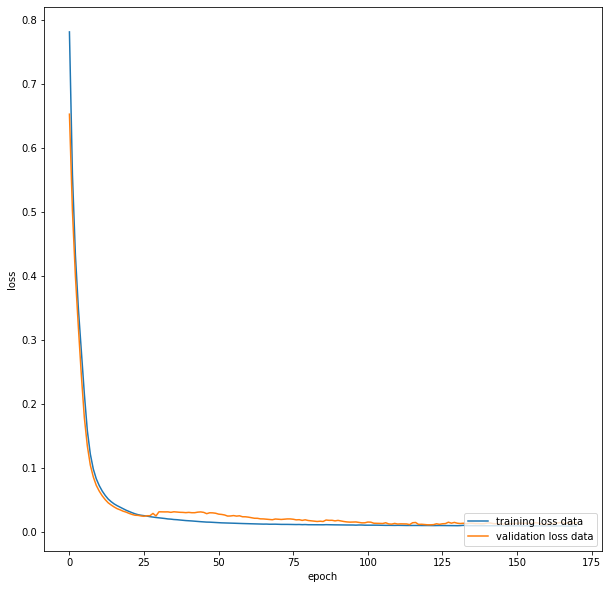

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history2.history['loss']) 
plt.plot(history2.history['val_loss']) 
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss data', 'validation loss data'], loc='lower right')
plt.show()

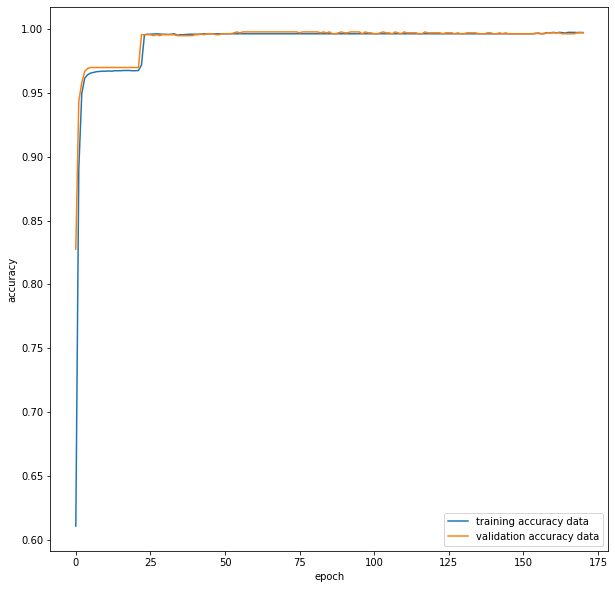

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy']) 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy data', 'validation accuracy data'], loc='lower right')
plt.show()

In [ ]:
# 4 layers (overfitting)
callback_b = EarlyStopping(monitor = 'val_loss', mode = 'auto' , patience = 50, verbose = 1)

modelF = Sequential()
modelF.add(Dense(5, input_dim = len(XTRAIN[0, :]), activation='relu'))
modelF.add(Dense(4, activation='relu'))
modelF.add(Dense(3, activation='relu'))
modelF.add(Dense(2, activation='relu'))
modelF.add(Dense(1, activation='sigmoid'))
modelF.compile(loss='binary_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])
historyF = modelF.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs = 512, batch_size=128, verbose = 1, callbacks = [callback_b])

Epoch 1/512
43/43 [==============================] - 1s 7ms/step - loss: 0.6457 - accuracy: 0.9655 - val_loss: 0.5697 - val_accuracy: 0.9707
Epoch 2/512
43/43 [==============================] - 0s 3ms/step - loss: 0.5436 - accuracy: 0.9668 - val_loss: 0.4543 - val_accuracy: 0.9707
Epoch 3/512
43/43 [==============================] - 0s 3ms/step - loss: 0.4256 - accuracy: 0.9699 - val_loss: 0.3367 - val_accuracy: 0.9707
Epoch 4/512
43/43 [==============================] - 0s 3ms/step - loss: 0.3112 - accuracy: 0.9667 - val_loss: 0.2344 - val_accuracy: 0.9707
Epoch 5/512
43/43 [==============================] - 0s 3ms/step - loss: 0.2144 - accuracy: 0.9692 - val_loss: 0.1596 - val_accuracy: 0.9707
Epoch 6/512
43/43 [==============================] - 0s 3ms/step - loss: 0.1444 - accuracy: 0.9700 - val_loss: 0.1113 - val_accuracy: 0.9707
Epoch 7/512
43/43 [==============================] - 0s 3ms/step - loss: 0.1074 - accuracy: 0.9670 - val_loss: 0.0818 - val_accuracy: 0.9707
Epoch 8/512
4

In [ ]:
scores = modelF.evaluate(XVALID, YVALID)
ypred = modelF.predict(XVALID)
accuracy = accuracy_score(YVALID, ypred.round()) * 100.0
precision = precision_score(YVALID, ypred.round()) * 100.0
recall = recall_score(YVALID, ypred.round()) * 100.0
f1score = f1_score(YVALID, ypred.round())

print("Accuracy: %.2f%%" % (accuracy))
print("Precision: %.2f%%" % (precision))
print("Recall: %.2f%%" % (recall))
print("F1-score: %.2f\n" % (f1score))

43/43 [==============================] - 0s 1ms/step - loss: 0.0195 - accuracy: 0.9978
Accuracy: 99.78%
Precision: 97.44%
Recall: 95.00%
F1-score: 0.96



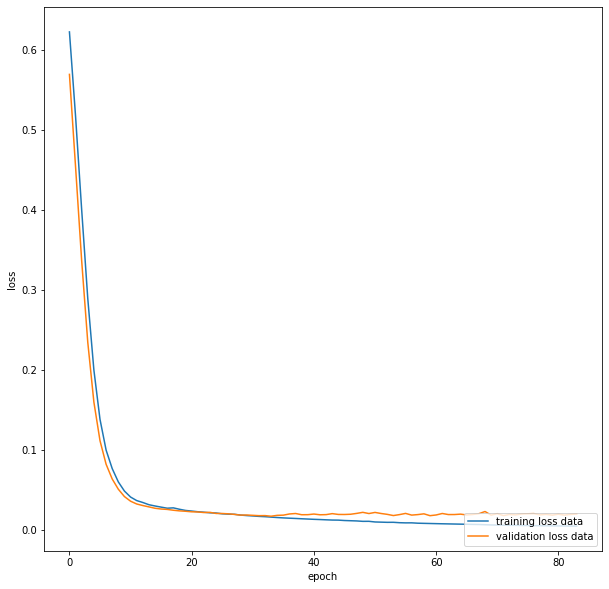

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(historyF.history['loss']) 
plt.plot(historyF.history['val_loss']) 
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss data', 'validation loss data'], loc='lower right')
plt.show()

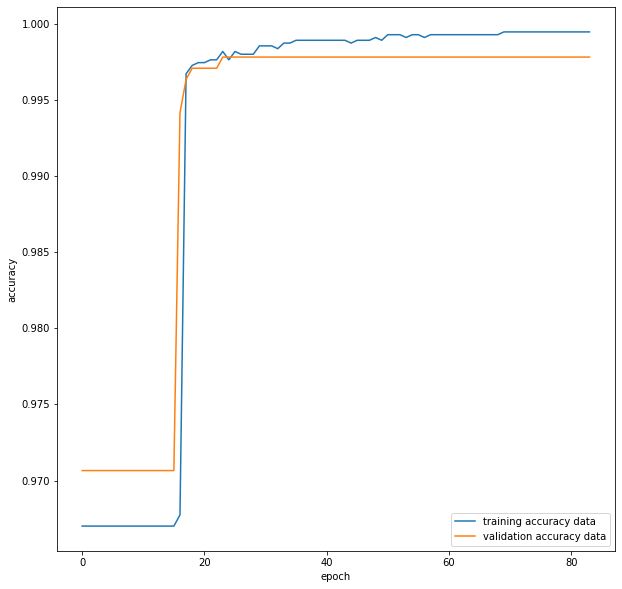

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(historyF.history['accuracy']) 
plt.plot(historyF.history['val_accuracy']) 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy data', 'validation accuracy data'], loc='lower right')
plt.show()

In [ ]:
# 5 layers
callback_b = EarlyStopping(monitor = 'val_loss', mode = 'auto' , patience = 50, verbose = 1)

modelSS = Sequential()
modelSS.add(Dense(6, input_dim = len(XTRAIN[0, :]), activation='relu'))
modelSS.add(Dense(5, activation='relu'))
modelSS.add(Dense(4, activation='relu'))
modelSS.add(Dense(3, activation='relu'))
modelSS.add(Dense(2, activation='relu'))
modelSS.add(Dense(1, activation='sigmoid'))
modelSS.compile(loss='binary_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])


In [ ]:
historySS = modelSS.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs = 512, batch_size=128, verbose = 1, callbacks = [callback_b])

Epoch 1/512
43/43 [==============================] - 1s 8ms/step - loss: 0.6862 - accuracy: 0.9297 - val_loss: 0.6690 - val_accuracy: 0.9699
Epoch 2/512
43/43 [==============================] - 0s 3ms/step - loss: 0.6644 - accuracy: 0.9659 - val_loss: 0.6496 - val_accuracy: 0.9707
Epoch 3/512
43/43 [==============================] - 0s 3ms/step - loss: 0.6450 - accuracy: 0.9702 - val_loss: 0.6308 - val_accuracy: 0.9707
Epoch 4/512
43/43 [==============================] - 0s 3ms/step - loss: 0.6266 - accuracy: 0.9676 - val_loss: 0.6123 - val_accuracy: 0.9707
Epoch 5/512
43/43 [==============================] - 0s 3ms/step - loss: 0.6094 - accuracy: 0.9618 - val_loss: 0.5943 - val_accuracy: 0.9707
Epoch 6/512
43/43 [==============================] - 0s 3ms/step - loss: 0.5900 - accuracy: 0.9704 - val_loss: 0.5768 - val_accuracy: 0.9707
Epoch 7/512
43/43 [==============================] - 0s 3ms/step - loss: 0.5734 - accuracy: 0.9676 - val_loss: 0.5598 - val_accuracy: 0.9707
Epoch 8/512
4

In [ ]:
scores = modelSS.evaluate(XVALID, YVALID)
ypred = modelSS.predict(XVALID)
accuracy = accuracy_score(YVALID, ypred.round()) * 100.0
precision = precision_score(YVALID, ypred.round()) * 100.0
recall = recall_score(YVALID, ypred.round()) * 100.0
f1score = f1_score(YVALID, ypred.round())

print("Accuracy: %.2f%%" % (accuracy))
print("Precision: %.2f%%" % (precision))
print("Recall: %.2f%%" % (recall))
print("F1-score: %.2f\n" % (f1score))

43/43 [==============================] - 0s 1ms/step - loss: 0.1327 - accuracy: 0.9707
Accuracy: 97.07%
Precision: 0.00%
Recall: 0.00%
F1-score: 0.00



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


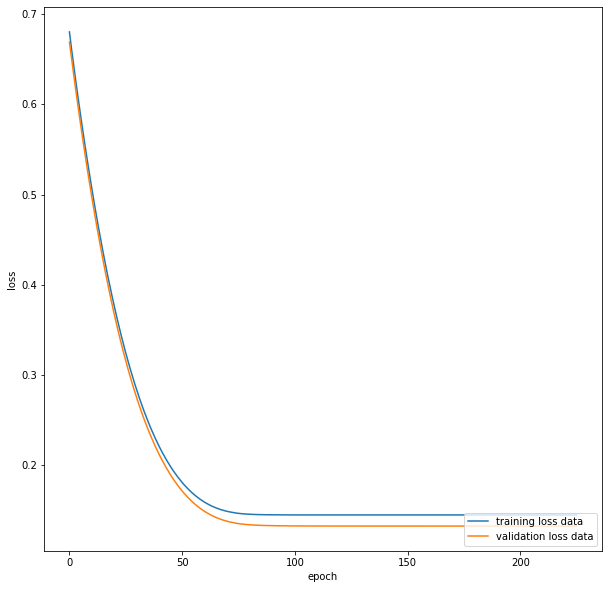

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(historySS.history['loss']) 
plt.plot(historySS.history['val_loss']) 
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss data', 'validation loss data'], loc='lower right')
plt.show()

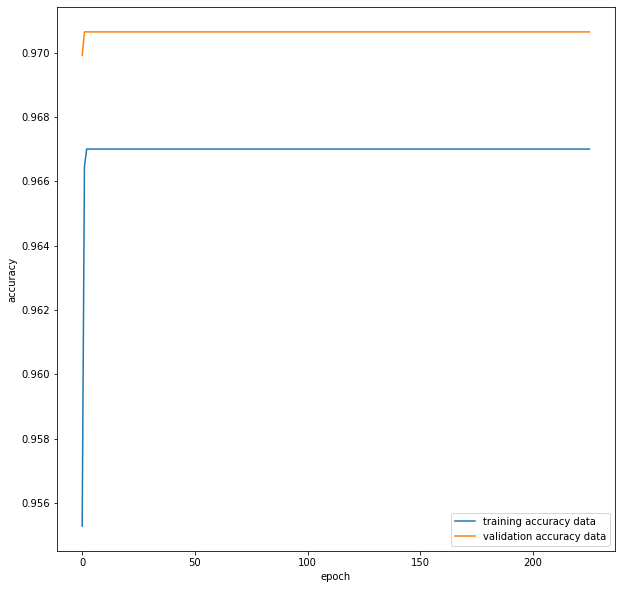

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(historySS.history['accuracy']) 
plt.plot(historySS.history['val_accuracy']) 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy data', 'validation accuracy data'], loc='lower right')
plt.show()

Determined that three layers are the best number of layers, and then experiment with neurons

**Best Model**

In [ ]:
# 3 layers with different neurons (best model)
callback_b = EarlyStopping(monitor = 'val_loss', mode = 'auto' , patience = 50, verbose = 1)

model3 = Sequential()
model3.add(Dense(5, input_dim = len(XTRAIN[0, :]), activation='relu'))
model3.add(Dense(4, activation='relu'))
model3.add(Dense(3, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])
history3 = model3.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs = 512, batch_size=128, verbose = 1, callbacks = [callback_b])

Epoch 1/512
43/43 [==============================] - 1s 7ms/step - loss: 0.7132 - accuracy: 0.4237 - val_loss: 0.6759 - val_accuracy: 0.9208
Epoch 2/512
43/43 [==============================] - 0s 3ms/step - loss: 0.6676 - accuracy: 0.9349 - val_loss: 0.6474 - val_accuracy: 0.9677
Epoch 3/512
43/43 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.9622 - val_loss: 0.6082 - val_accuracy: 0.9685
Epoch 4/512
43/43 [==============================] - 0s 3ms/step - loss: 0.5956 - accuracy: 0.9623 - val_loss: 0.5482 - val_accuracy: 0.9692
Epoch 5/512
43/43 [==============================] - 0s 3ms/step - loss: 0.5317 - accuracy: 0.9674 - val_loss: 0.4701 - val_accuracy: 0.9714
Epoch 6/512
43/43 [==============================] - 0s 3ms/step - loss: 0.4492 - accuracy: 0.9666 - val_loss: 0.3824 - val_accuracy: 0.9707
Epoch 7/512
43/43 [==============================] - 0s 3ms/step - loss: 0.3644 - accuracy: 0.9686 - val_loss: 0.2944 - val_accuracy: 0.9707
Epoch 8/512
4

In [ ]:
scores = model3.evaluate(XVALID, YVALID)
ypred = model3.predict(XVALID)
accuracy = accuracy_score(YVALID, ypred.round()) * 100.0
precision = precision_score(YVALID, ypred.round()) * 100.0
recall = recall_score(YVALID, ypred.round()) * 100.0
f1score = f1_score(YVALID, ypred.round())

print("Accuracy: %.2f%%" % (accuracy))
print("Precision: %.2f%%" % (precision))
print("Recall: %.2f%%" % (recall))
print("F1-score: %.2f\n" % (f1score))

43/43 [==============================] - 0s 1ms/step - loss: 0.0014 - accuracy: 0.9993
Accuracy: 99.93%
Precision: 100.00%
Recall: 97.50%
F1-score: 0.99



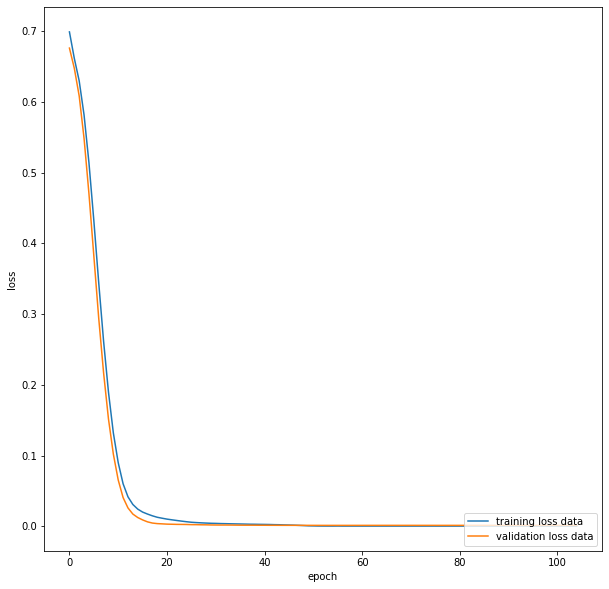

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history3.history['loss']) 
plt.plot(history3.history['val_loss']) 
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss data', 'validation loss data'], loc='lower right')
plt.show()

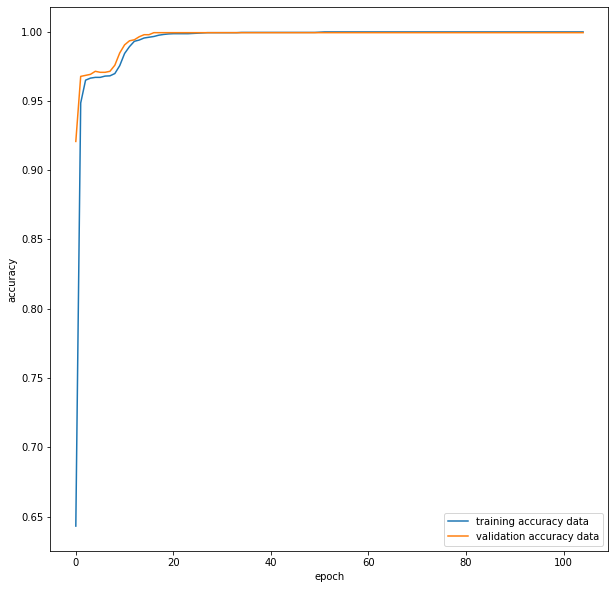

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history3.history['accuracy']) 
plt.plot(history3.history['val_accuracy']) 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy data', 'validation accuracy data'], loc='lower right')
plt.show()

In [ ]:
#  3 layers with different neurons(overfitting)
callback_b = EarlyStopping(monitor = 'val_loss', mode = 'auto' , patience = 50, verbose = 1)

model4 = Sequential()
model4.add(Dense(6, input_dim = len(XTRAIN[0, :]), activation='relu'))
model4.add(Dense(4, activation='relu'))
model4.add(Dense(3, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))
model4.compile(loss='binary_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])


In [ ]:
history4 = model4.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs = 512, batch_size=128, verbose = 1, callbacks = [callback_b])

Epoch 1/512
43/43 [==============================] - 1s 7ms/step - loss: 0.8882 - accuracy: 0.3704 - val_loss: 0.5987 - val_accuracy: 0.6764
Epoch 2/512
43/43 [==============================] - 0s 3ms/step - loss: 0.5623 - accuracy: 0.7939 - val_loss: 0.4206 - val_accuracy: 0.9648
Epoch 3/512
43/43 [==============================] - 0s 3ms/step - loss: 0.4033 - accuracy: 0.9639 - val_loss: 0.3055 - val_accuracy: 0.9861
Epoch 4/512
43/43 [==============================] - 0s 3ms/step - loss: 0.2849 - accuracy: 0.9758 - val_loss: 0.2129 - val_accuracy: 0.9729
Epoch 5/512
43/43 [==============================] - 0s 3ms/step - loss: 0.2019 - accuracy: 0.9676 - val_loss: 0.1355 - val_accuracy: 0.9707
Epoch 6/512
43/43 [==============================] - 0s 3ms/step - loss: 0.1268 - accuracy: 0.9677 - val_loss: 0.0833 - val_accuracy: 0.9707
Epoch 7/512
43/43 [==============================] - 0s 3ms/step - loss: 0.0865 - accuracy: 0.9658 - val_loss: 0.0553 - val_accuracy: 0.9802
Epoch 8/512
4

In [ ]:
scores = model4.evaluate(XVALID, YVALID)
ypred = model4.predict(XVALID)
accuracy = accuracy_score(YVALID, ypred.round()) * 100.0
precision = precision_score(YVALID, ypred.round()) * 100.0
recall = recall_score(YVALID, ypred.round()) * 100.0
f1score = f1_score(YVALID, ypred.round())

print("Accuracy: %.2f%%" % (accuracy))
print("Precision: %.2f%%" % (precision))
print("Recall: %.2f%%" % (recall))
print("F1-score: %.2f\n" % (f1score))

43/43 [==============================] - 0s 973us/step - loss: 0.0124 - accuracy: 0.9985
Accuracy: 99.85%
Precision: 95.24%
Recall: 100.00%
F1-score: 0.98



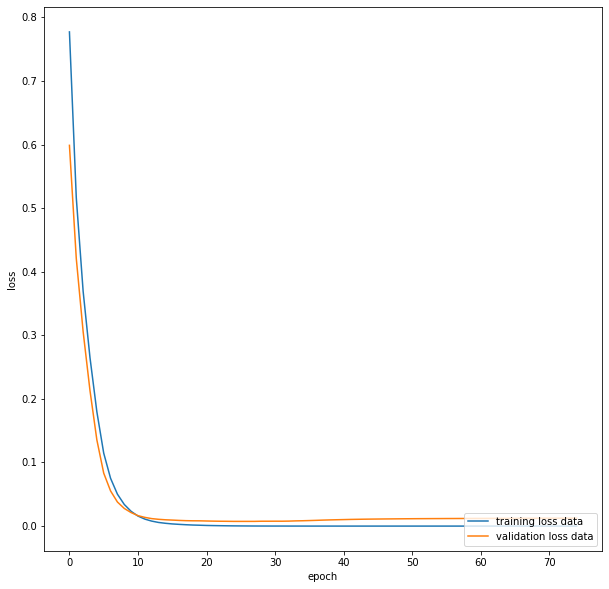

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss']) 
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss data', 'validation loss data'], loc='lower right')
plt.show()

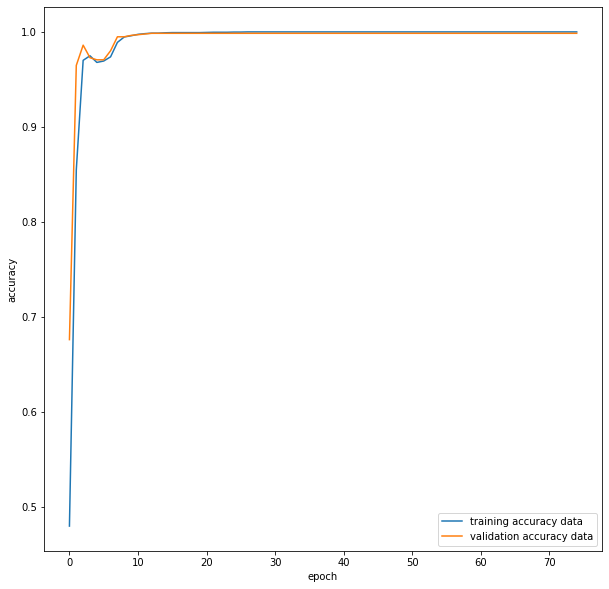

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history4.history['accuracy']) 
plt.plot(history4.history['val_accuracy']) 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy data', 'validation accuracy data'], loc='lower right')
plt.show()

In [ ]:
#  3 layers with different neurons(overfitting)
callback_b = EarlyStopping(monitor = 'val_loss', mode = 'auto' , patience = 50, verbose = 1)

model3s = Sequential()
model3s.add(Dense(5, input_dim = len(XTRAIN[0, :]), activation='relu'))
model3s.add(Dense(3, activation='relu'))
model3s.add(Dense(2, activation='relu'))
model3s.add(Dense(1, activation='sigmoid'))
model3s.compile(loss='binary_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])

In [ ]:
history3s =model3s.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs = 512, batch_size=128, verbose = 1, callbacks = [callback_b])

Epoch 1/512
43/43 [==============================] - 1s 7ms/step - loss: 0.8048 - accuracy: 0.2832 - val_loss: 0.7153 - val_accuracy: 0.6581
Epoch 2/512
43/43 [==============================] - 0s 3ms/step - loss: 0.6947 - accuracy: 0.7785 - val_loss: 0.6666 - val_accuracy: 0.9420
Epoch 3/512
43/43 [==============================] - 0s 3ms/step - loss: 0.6528 - accuracy: 0.9530 - val_loss: 0.6384 - val_accuracy: 0.9699
Epoch 4/512
43/43 [==============================] - 0s 3ms/step - loss: 0.6255 - accuracy: 0.9782 - val_loss: 0.6154 - val_accuracy: 0.9787
Epoch 5/512
43/43 [==============================] - 0s 3ms/step - loss: 0.6028 - accuracy: 0.9880 - val_loss: 0.5931 - val_accuracy: 0.9831
Epoch 6/512
43/43 [==============================] - 0s 3ms/step - loss: 0.5812 - accuracy: 0.9900 - val_loss: 0.5720 - val_accuracy: 0.9846
Epoch 7/512
43/43 [==============================] - 0s 3ms/step - loss: 0.5614 - accuracy: 0.9933 - val_loss: 0.5515 - val_accuracy: 0.9875
Epoch 8/512
4

In [ ]:
scores = model3s.evaluate(XVALID, YVALID)
ypred = model3s.predict(XVALID)
accuracy = accuracy_score(YVALID, ypred.round()) * 100.0
precision = precision_score(YVALID, ypred.round()) * 100.0
recall = recall_score(YVALID, ypred.round()) * 100.0
f1score = f1_score(YVALID, ypred.round())

print("Accuracy: %.2f%%" % (accuracy))
print("Precision: %.2f%%" % (precision))
print("Recall: %.2f%%" % (recall))
print("F1-score: %.2f\n" % (f1score))

43/43 [==============================] - 0s 1ms/step - loss: 0.0157 - accuracy: 0.9971
Accuracy: 99.71%
Precision: 92.86%
Recall: 97.50%
F1-score: 0.95



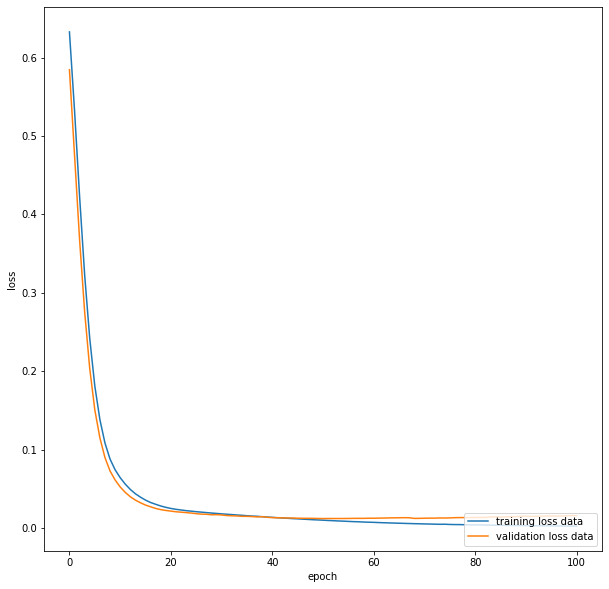

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history3s.history['loss'])
plt.plot(history3s.history['val_loss']) 
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss data', 'validation loss data'], loc='lower right')
plt.show()

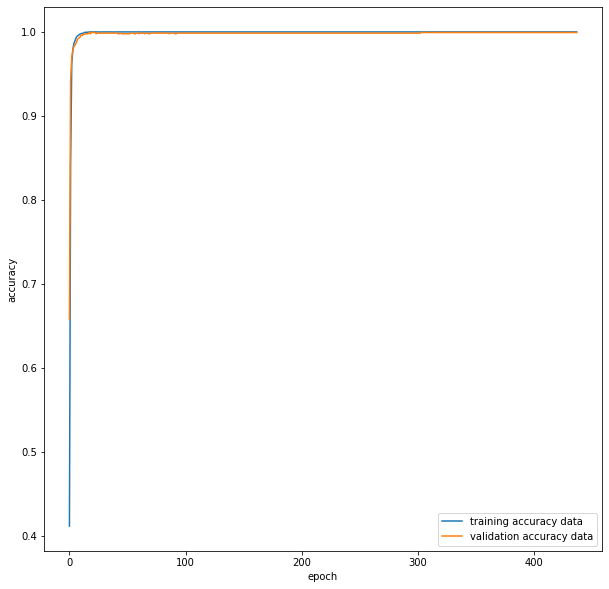

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history3s.history['accuracy']) 
plt.plot(history3s.history['val_accuracy']) 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy data', 'validation accuracy data'], loc='lower right')
plt.show()

### Overfitting

In [ ]:
#callback_b = EarlyStopping(monitor = 'val_loss', mode = 'auto' , patience = 50, verbose = 1)
# without the EarlyStopping the best model will be overfit
## Baseline Model #3
modelO = Sequential()
modelO.add(Dense(5, input_dim = len(XTRAIN[0, :]), activation='relu'))
modelO.add(Dense(4, activation='relu'))
modelO.add(Dense(3, activation='relu'))
modelO.add(Dense(1, activation='sigmoid'))
modelO.compile(loss='binary_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])


In [ ]:
historyO = modelO.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs = 512, batch_size=128, verbose = 1, )

Epoch 1/800
43/43 [==============================] - 1s 6ms/step - loss: 0.6917 - accuracy: 0.5355 - val_loss: 0.6310 - val_accuracy: 0.9574
Epoch 2/800
43/43 [==============================] - 0s 3ms/step - loss: 0.6140 - accuracy: 0.9516 - val_loss: 0.5429 - val_accuracy: 0.9699
Epoch 3/800
43/43 [==============================] - 0s 3ms/step - loss: 0.5260 - accuracy: 0.9651 - val_loss: 0.4577 - val_accuracy: 0.9714
Epoch 4/800
43/43 [==============================] - 0s 3ms/step - loss: 0.4439 - accuracy: 0.9640 - val_loss: 0.3822 - val_accuracy: 0.9707
Epoch 5/800
43/43 [==============================] - 0s 3ms/step - loss: 0.3656 - accuracy: 0.9669 - val_loss: 0.3167 - val_accuracy: 0.9707
Epoch 6/800
43/43 [==============================] - 0s 3ms/step - loss: 0.3032 - accuracy: 0.9621 - val_loss: 0.2536 - val_accuracy: 0.9707
Epoch 7/800
43/43 [==============================] - 0s 3ms/step - loss: 0.2428 - accuracy: 0.9696 - val_loss: 0.1936 - val_accuracy: 0.9707
Epoch 8/800
4

In [ ]:
scores = modelO.evaluate(XVALID, YVALID)
ypred = modelO.predict(XVALID)
ypred = (ypred > 0.5)
cm = confusion_matrix(YVALID, ypred)
acc = (cm[0, 0] + cm[1, 1]) / sum(cm.flatten()) * 100
print("\n%s" % cm)
print("%s%%\n" % acc)




accuracy = accuracy_score(YVALID, ypred.round()) * 100.0
precision = precision_score(YVALID, ypred.round()) * 100.0
recall = recall_score(YVALID, ypred.round()) * 100.0
f1score = f1_score(YVALID, ypred.round())

print("Accuracy: %.2f%%" % (accuracy))
print("Precision: %.2f%%" % (precision))
print("Recall: %.2f%%" % (recall))
print("F1-score: %.2f\n" % (f1score))

43/43 [==============================] - 0s 960us/step - loss: 0.0141 - accuracy: 0.9985

[[1323    0]
 [   2   38]]
99.85326485693324%

Accuracy: 99.85%
Precision: 100.00%
Recall: 95.00%
F1-score: 0.97



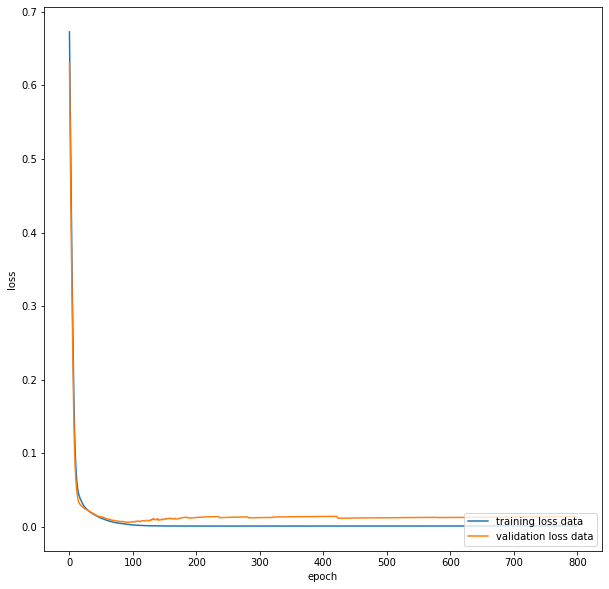

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(historyO.history['loss']) 
plt.plot(historyO.history['val_loss']) 
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss data', 'validation loss data'], loc='lower right')
plt.show()

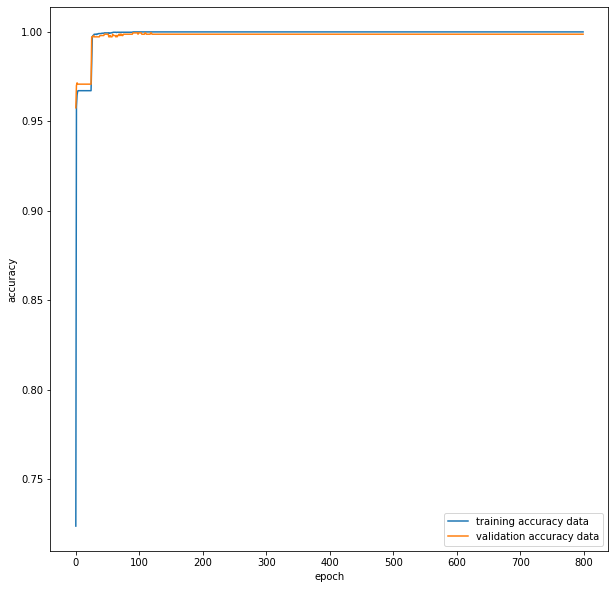

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(historyO.history['accuracy']) 
plt.plot(historyO.history['val_accuracy']) 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy data', 'validation accuracy data'], loc='lower right')
plt.show()

### The best neural network architecture the performance difference when linear activation is used instead of sigmoid 

In [ ]:
# Compare Model 
callback_b = EarlyStopping(monitor = 'val_loss', mode = 'auto' , patience = 50, verbose = 1)

modelP = Sequential()
modelP.add(Dense(5, input_dim = len(XTRAIN[0, :]), activation='relu'))
modelP.add(Dense(4, activation='relu'))
modelP.add(Dense(3, activation='relu'))
modelP.add(Dense(1, activation='linear'))
modelP.compile(loss='binary_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])


In [ ]:
historyP = modelP.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs = 512, batch_size=128, verbose = 1, callbacks = [callback_b])

Epoch 1/512
43/43 [==============================] - 1s 7ms/step - loss: 0.1941 - accuracy: 0.9671 - val_loss: 0.1062 - val_accuracy: 0.9751
Epoch 2/512
43/43 [==============================] - 0s 3ms/step - loss: 0.1109 - accuracy: 0.9713 - val_loss: 0.0966 - val_accuracy: 0.9809
Epoch 3/512
43/43 [==============================] - 0s 3ms/step - loss: 0.0823 - accuracy: 0.9808 - val_loss: 0.0712 - val_accuracy: 0.9883
Epoch 4/512
43/43 [==============================] - 0s 3ms/step - loss: 0.0700 - accuracy: 0.9900 - val_loss: 0.0550 - val_accuracy: 0.9934
Epoch 5/512
43/43 [==============================] - 0s 3ms/step - loss: 0.0494 - accuracy: 0.9943 - val_loss: 0.0524 - val_accuracy: 0.9949
Epoch 6/512
43/43 [==============================] - 0s 3ms/step - loss: 0.0450 - accuracy: 0.9947 - val_loss: 0.0490 - val_accuracy: 0.9956
Epoch 7/512
43/43 [==============================] - 0s 3ms/step - loss: 0.0447 - accuracy: 0.9963 - val_loss: 0.0482 - val_accuracy: 0.9956
Epoch 8/512
4

In [ ]:
pPLinT = modelP.predict(XTRAIN)
pPLinV = modelP.predict(XVALID)
errorPT = pPLinT - YTRAIN
errorPV = pPLinV - YVALID
print("Training MSE: " + str(np.square(errorPT).mean()))
print("Validation MSE: " + str(np.square(errorPV).mean()))

Training MSE: 0.8135905693938253
Validation MSE: 0.8291432997627048


In [ ]:
scores = modelP.evaluate(XVALID, YVALID)
ypred = modelP.predict(XVALID)
ypred = (ypred > 0.5)
cm = confusion_matrix(YVALID, ypred)
acc = (cm[0, 0] + cm[1, 1]) / sum(cm.flatten()) * 100
print("\n%s" % cm)
print("%s%%\n" % acc)




accuracy = accuracy_score(YVALID, ypred.round()) * 100.0
precision = precision_score(YVALID, ypred.round()) * 100.0
recall = recall_score(YVALID, ypred.round()) * 100.0
f1score = f1_score(YVALID, ypred.round())

print("Accuracy: %.2f%%" % (accuracy))
print("Precision: %.2f%%" % (precision))
print("Recall: %.2f%%" % (recall))
print("F1-score: %.2f\n" % (f1score))

43/43 [==============================] - 0s 2ms/step - loss: 0.0454 - accuracy: 0.9971

[[1322    1]
 [   3   37]]
99.70652971386647%

Accuracy: 99.71%
Precision: 97.37%
Recall: 92.50%
F1-score: 0.95



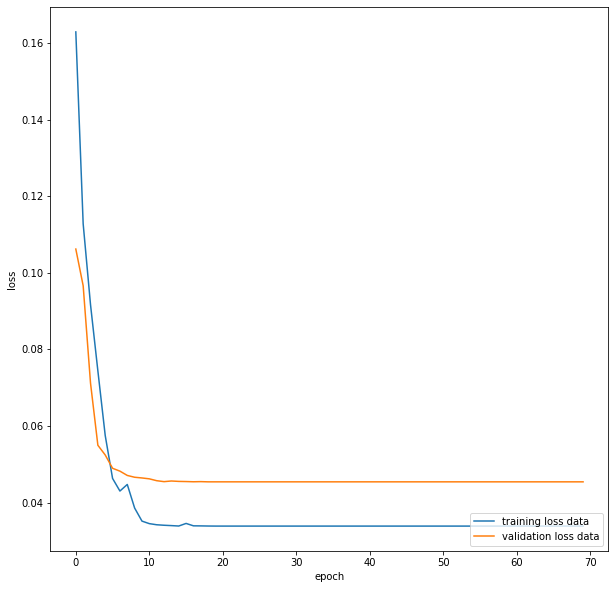

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(historyP.history['loss']) 
plt.plot(historyP.history['val_loss']) 
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss data', 'validation loss data'], loc='lower right')
plt.show()

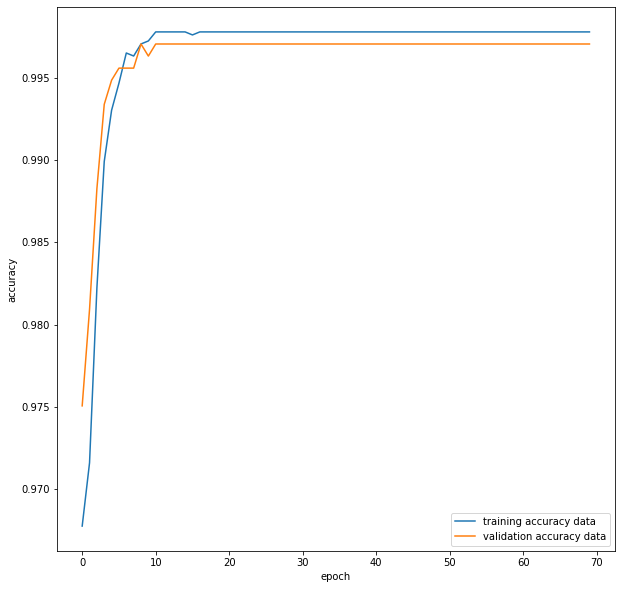

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(historyP.history['accuracy']) 
plt.plot(historyP.history['val_accuracy']) 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy data', 'validation accuracy data'], loc='lower right')
plt.show()

## Feature importance

### Oversampling（SMOTE）

In phase 3 I found out that features of the dataset are not obvious. Most of the features are at the same level in the plot. The reason why it happens is that the dataset is imbalanced cause the baseline accuracy is high. To solve this I use the oversampling technique to balance the dataset. So we need to reload the dataset and do the split and normalization one more time.

In [14]:
# Convert to Numpy Array
dataset_np = dataset.values
X = dataset.drop('Bankrupt?', axis='columns').values
Y = dataset['Bankrupt?'].values

In [15]:
# oversampling 
oversample = SMOTE()
X,Y=oversample.fit_resample(X,Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


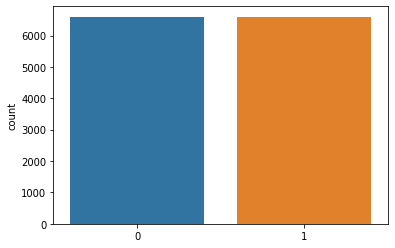

In [16]:
# after SMOTE the dataset is balance
sns.countplot(x=Y)

In [17]:
# Data standardizatin
scaler=StandardScaler()
X_scale=scaler.fit_transform(X)

In [18]:
# Shuffle and Split data
XTRAIN, XVALID, YTRAIN, YVALID = train_test_split(X_scale, Y, test_size = 0.2, random_state = 1)

### Importance of Features

In [ ]:
feature_columns = []
importance_feature = []

for index in range(dataset.shape[1]-1):
    
    x = dataset[dataset.columns[index]].values
    y = dataset['Bankrupt?'].values
    i_20 = int(0.2 * len(dataset_np[:, 0]))

    xvalid = x[:i_20]
    yvalid = y[:i_20]
    xtrain = x[i_20:]
    ytrain = y[i_20:]


    min = xtrain.min(axis=0)
    max = xtrain.max(axis=0)
    mean = xtrain.mean(axis=0)
    xtrain = (xtrain - mean) / (max - min)
    xvalid = (xvalid - mean) / (max - min)
    ymax = ytrain.max()
    ytrain = ytrain / ymax
    yvalid = yvalid / ymax

    callback_a = ModelCheckpoint(filepath="removal.hdf5", monitor='val_loss', save_best_only=True,save_weights_only=True, verbose=0)
    callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=0)

    model = Sequential()
    model.add(Dense(5, input_dim=1, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), epochs=32, batch_size=100,callbacks=[callback_a, callback_b], verbose=0)

    prediction = model.predict(xvalid, verbose=0)
    prediction = (prediction > 0.5)
    acc_score = accuracy_score(yvalid, prediction)
    feature_columns.append(dataset.columns[index])
    importance_feature.append(acc_score)
    print("%s | %s | %s" % (
    datetime.datetime.now(pytz.timezone('US/Central')).strftime("%Y/%m/%d %I:%M:%S %p"), dataset.columns[index],
    acc_score))

print()
print(feature_columns)
print(importance_feature)

2021/05/10 10:07:39 AM |  ROA(C) before interest and depreciation before interest | 0.9515774027879678
2021/05/10 10:07:44 AM |  ROA(A) before interest and % after tax | 0.9515774027879678
2021/05/10 10:07:49 AM |  ROA(B) before interest and depreciation after tax | 0.9515774027879678
2021/05/10 10:07:54 AM |  Operating Gross Margin | 0.9515774027879678
2021/05/10 10:07:59 AM |  Realized Sales Gross Margin | 0.9515774027879678
2021/05/10 10:08:04 AM |  Operating Profit Rate | 0.9515774027879678
2021/05/10 10:08:08 AM |  Pre-tax net Interest Rate | 0.9515774027879678
2021/05/10 10:08:13 AM |  After-tax net Interest Rate | 0.9515774027879678
2021/05/10 10:08:17 AM |  Non-industry income and expenditure/revenue | 0.9515774027879678
2021/05/10 10:08:21 AM |  Continuous interest rate (after tax) | 0.9515774027879678
2021/05/10 10:08:25 AM |  Operating Expense Rate | 0.9515774027879678
2021/05/10 10:08:30 AM |  Research and development expense rate | 0.9515774027879678
2021/05/10 10:08:34 AM

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


2021/05/10 10:14:40 AM |  Net Income Flag | 0.9515774027879678
2021/05/10 10:14:45 AM |  Equity to Liability | 0.9515774027879678

[' ROA(C) before interest and depreciation before interest', ' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Operating Gross Margin', ' Realized Sales Gross Margin', ' Operating Profit Rate', ' Pre-tax net Interest Rate', ' After-tax net Interest Rate', ' Non-industry income and expenditure/revenue', ' Continuous interest rate (after tax)', ' Operating Expense Rate', ' Research and development expense rate', ' Cash flow rate', ' Interest-bearing debt interest rate', ' Tax rate (A)', ' Net Value Per Share (B)', ' Net Value Per Share (A)', ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons', ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)', ' Operating Profit Per Share (Yuan ¥)', ' Per Share Net profit before tax (Yuan ¥)', ' Realized Sales Gross Profit Growth Rate', ' Operating Profit

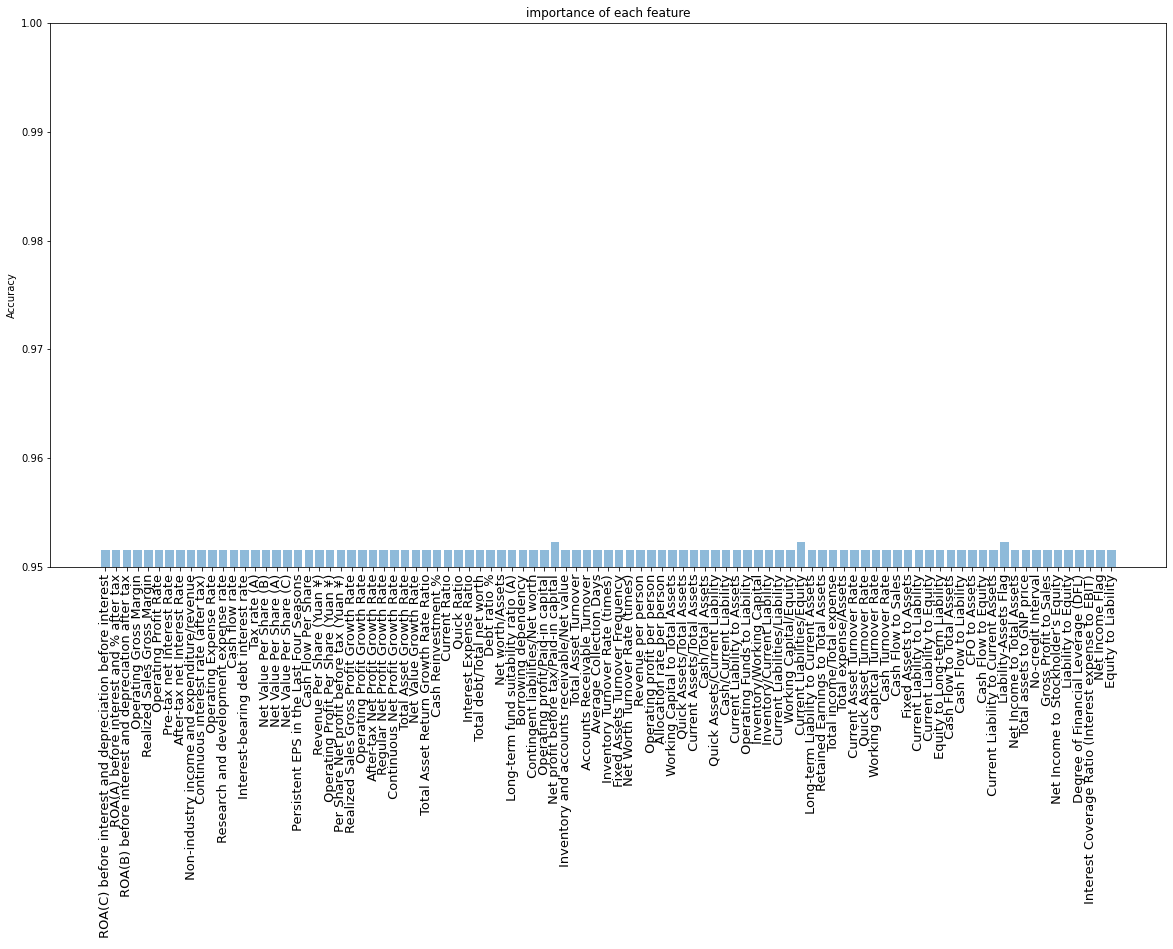

In [ ]:
y = np.arange(len(feature_columns))
plt.figure(figsize=(20, 10))
plt.bar(y, importance_feature, align='center', alpha=0.5)
plt.xticks(y, feature_columns, fontsize=13, rotation=90)
plt.ylim(0.95, 1)
plt.ylabel('Accuracy')
plt.title('importance of each feature')
plt.show()

### Recursive Feature Elimination(remove one feature a time) 

In [ ]:
feature_columns = []
performance_feature = []

for index in range(dataset.shape[1]-1):

    x = dataset.drop([dataset.columns[index], 'Bankrupt?'], axis='columns').values
    y = dataset['Bankrupt?'].values
    i_20 = int(0.2 * len(dataset_np[:, 0]))

    xvalid = x[:i_20]
    yvalid = y[:i_20]
    xtrain = x[i_20:]
    ytrain = y[i_20:]

    min = xtrain.min(axis = 0) 
    max = xtrain.max(axis = 0) 
    mean = xtrain.mean(axis = 0)
    xtrain = (xtrain - mean) / (max - min)
    xvalid = (xvalid - mean) / (max - min)
    ymax = ytrain.max()
    ytrain = ytrain / ymax
    yvalid = yvalid / ymax

    callback_a = ModelCheckpoint(filepath = "removal.hdf5", monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=0)
    callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=0)

    model = Sequential()
    model.add(Dense(5, input_dim=len(xtrain[0, :]), activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    history = model.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), epochs=32, batch_size=100, callbacks=[callback_a, callback_b], verbose=0)
    
    prediction = model.predict(xvalid, verbose=0)
    prediction = (prediction > 0.5)
    acc_score = accuracy_score(yvalid, prediction)
    feature_columns.append(dataset.columns[index])
    performance_feature.append(acc_score)
    print("%s | %s | %s" % (datetime.datetime.now(pytz.timezone('US/Central')).strftime("%Y/%m/%d %I:%M:%S %p"), dataset.columns[index], acc_score))

print()
print(feature_columns)
print(performance_feature)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


2021/05/10 09:43:41 AM |  ROA(C) before interest and depreciation before interest | 0.9515774027879678
2021/05/10 09:43:45 AM |  ROA(A) before interest and % after tax | 0.9515774027879678
2021/05/10 09:43:48 AM |  ROA(B) before interest and depreciation after tax | 0.9515774027879678
2021/05/10 09:43:52 AM |  Operating Gross Margin | 0.9515774027879678
2021/05/10 09:43:55 AM |  Realized Sales Gross Margin | 0.9515774027879678
2021/05/10 09:43:59 AM |  Operating Profit Rate | 0.9515774027879678
2021/05/10 09:44:02 AM |  Pre-tax net Interest Rate | 0.9515774027879678
2021/05/10 09:44:06 AM |  After-tax net Interest Rate | 0.9515774027879678
2021/05/10 09:44:10 AM |  Non-industry income and expenditure/revenue | 0.9515774027879678
2021/05/10 09:44:13 AM |  Continuous interest rate (after tax) | 0.9515774027879678
2021/05/10 09:44:17 AM |  Operating Expense Rate | 0.9515774027879678
2021/05/10 09:44:21 AM |  Research and development expense rate | 0.9515774027879678
2021/05/10 09:44:24 AM

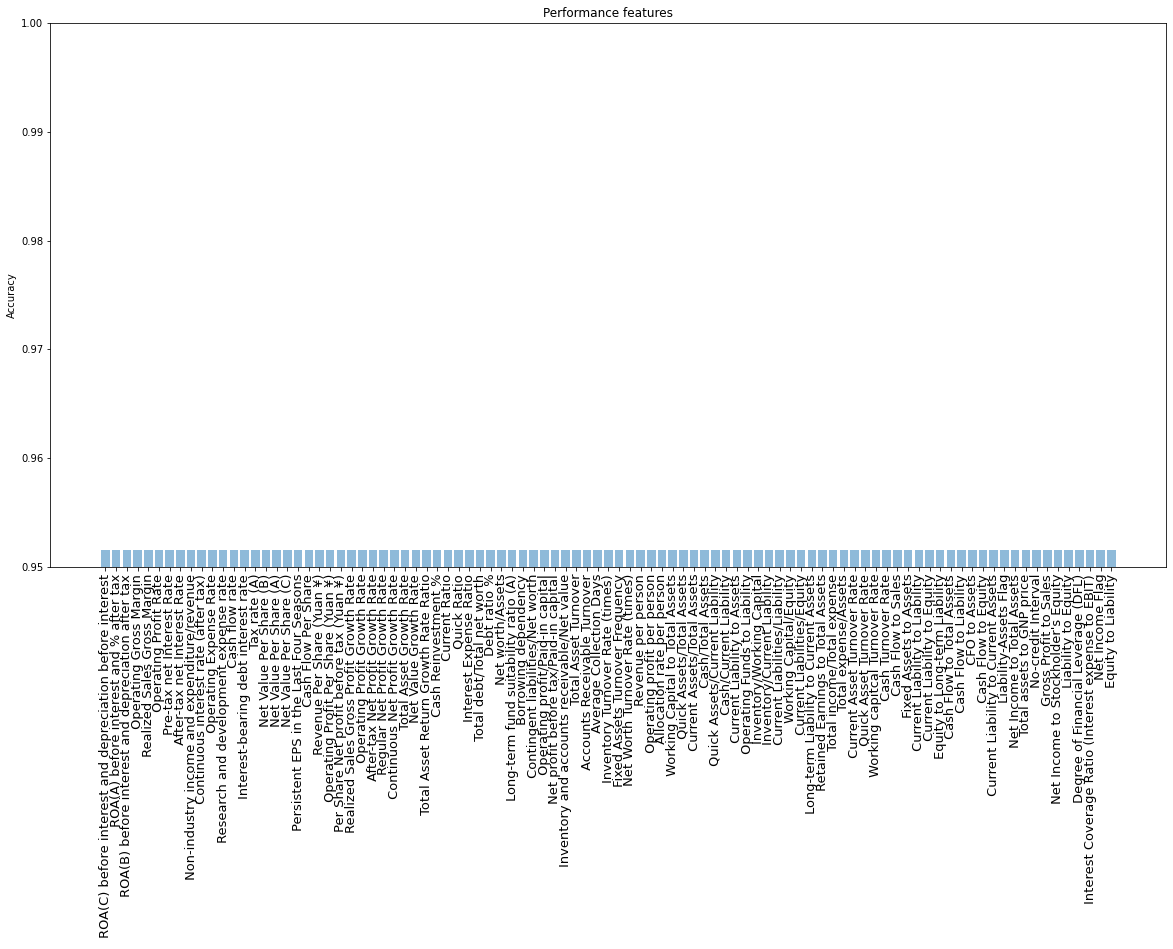

In [ ]:
y = np.arange(len(feature_columns))
plt.figure(figsize=(20, 10))
plt.bar(y, performance_feature, align='center', alpha=0.5)
plt.xticks(y, feature_columns, fontsize=13, rotation=90)
plt.ylim(0.95, 1)
plt.ylabel('Accuracy')
plt.title('Performance features')
plt.show()

### Remove too Low Variance

The previous experiment results are not obvious, so I use another method to do feauture selection

In [ ]:
data_mean = np.mean(dataset, axis=0)
variance = np.var(dataset/data_mean, axis=0)
var_df = pd.DataFrame(variance,columns=['variance'])
var_df.sort_values(by='variance').style.background_gradient(sns.light_palette('red', as_cmap=True))

,variance
Net Income Flag,0.000000
Operating Profit Growth Rate,0.000161
Operating Profit Rate,0.000170
Cash Flow to Sales,0.000193
Working capitcal Turnover Rate,0.000227
Working Capital/Equity,0.000252
Pre-tax net Interest Rate,0.000261
Continuous interest rate (after tax),0.000263
After-tax net Interest Rate,0.000283
Net Income to Stockholder's Equity,0.000299


In [ ]:
vt = VarianceThreshold(5.0).fit(dataset/data_mean)
vt_transform = vt.transform(dataset/data_mean)

In [ ]:
high_var_cols = dataset.columns[vt.get_support()]
low_var_cols = dataset.columns[~vt.get_support()]

print("Removed cols :",len(low_var_cols))
print("Remaining cols :",len(high_var_cols))

Removed cols : 74
Remaining cols : 22


### Recursive Feature Elimination

In [ ]:
# RFE using RandomForest
rfe = RFE(estimator = RandomForestClassifier(n_estimators=300, class_weight=None), n_features_to_select=22,step=1, verbose=1).fit(X, Y)

Fitting estimator with 95 features.


In [ ]:
vt_transform_rfe = rfe.transform(XTRAIN)
vt_transform_rfe.shape

(13198, 22)

In [ ]:
print('Optimal number of features: {}'.format(rfe.n_features_))

Optimal number of features: 22


In [ ]:
XTRAIN, XVALID, YTRAIN, YVALID = train_test_split(vt_transform_rfe, Y, test_size = 0.2, random_state = 1)

### The Performance of Best Model After RFE

In [ ]:
# 3 layers with different neurons (best model)
callback_b = EarlyStopping(monitor = 'val_loss', mode = 'auto' , patience = 50, verbose = 1)

modelrfe = Sequential()
modelrfe.add(Dense(5, input_dim = len(XTRAIN[0, :]), activation='relu'))
modelrfe.add(Dense(4, activation='relu'))
modelrfe.add(Dense(3, activation='relu'))
modelrfe.add(Dense(1, activation='sigmoid'))
modelrfe.compile(loss='binary_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])

In [ ]:
historyrfe = modelrfe.fit(XTRAIN, YTRAIN, validation_data=(XVALID, YVALID), epochs = 512, batch_size=128, verbose = 1,callbacks = [callback_b] )

Epoch 1/512
43/43 [==============================] - 1s 5ms/step - loss: 0.5523 - accuracy: 0.8388 - val_loss: 0.4104 - val_accuracy: 0.9435
Epoch 2/512
43/43 [==============================] - 0s 2ms/step - loss: 0.3842 - accuracy: 0.9533 - val_loss: 0.2827 - val_accuracy: 0.9553
Epoch 3/512
43/43 [==============================] - 0s 2ms/step - loss: 0.2718 - accuracy: 0.9665 - val_loss: 0.2047 - val_accuracy: 0.9597
Epoch 4/512
43/43 [==============================] - 0s 2ms/step - loss: 0.1894 - accuracy: 0.9611 - val_loss: 0.1640 - val_accuracy: 0.9597
Epoch 5/512
43/43 [==============================] - 0s 2ms/step - loss: 0.1531 - accuracy: 0.9695 - val_loss: 0.1420 - val_accuracy: 0.9597
Epoch 6/512
43/43 [==============================] - 0s 2ms/step - loss: 0.1322 - accuracy: 0.9686 - val_loss: 0.1305 - val_accuracy: 0.9597
Epoch 7/512
43/43 [==============================] - 0s 2ms/step - loss: 0.1223 - accuracy: 0.9698 - val_loss: 0.1234 - val_accuracy: 0.9597
Epoch 8/512
4

In [ ]:
scores = modelrfe.evaluate(XVALID, YVALID)
ypred = modelrfe.predict(XVALID)
accuracy = accuracy_score(YVALID, ypred.round()) * 100.0
precision = precision_score(YVALID, ypred.round()) * 100.0
recall = recall_score(YVALID, ypred.round()) * 100.0
f1score = f1_score(YVALID, ypred.round())

print("Accuracy: %.2f%%" % (accuracy))
print("Precision: %.2f%%" % (precision))
print("Recall: %.2f%%" % (recall))
print("F1-score: %.2f\n" % (f1score))

43/43 [==============================] - 0s 757us/step - loss: 0.1191 - accuracy: 0.9648
Accuracy: 96.48%
Precision: 52.78%
Recall: 38.00%
F1-score: 0.44



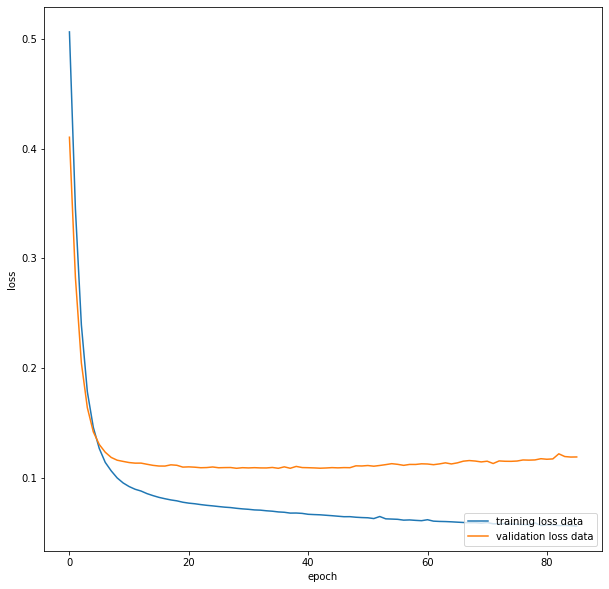

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(historyrfe.history['loss']) 
plt.plot(historyrfe.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss data', 'validation loss data'], loc='lower right')
plt.show()

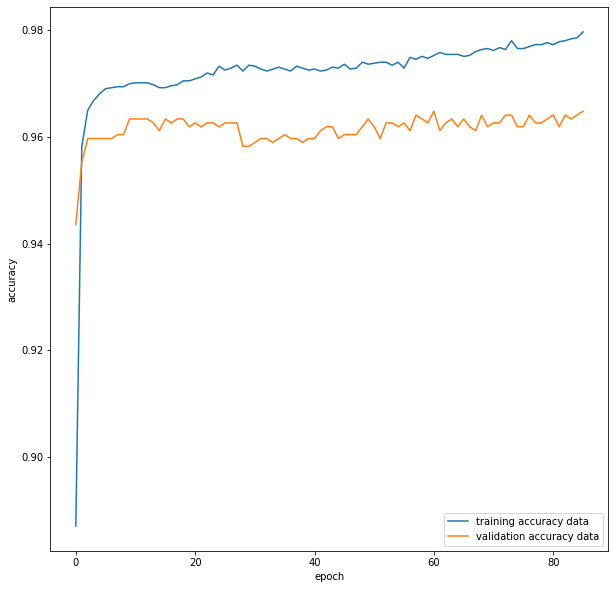

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(historyrfe.history['accuracy']) 
plt.plot(historyrfe.history['val_accuracy']) 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy data', 'validation accuracy data'], loc='lower right')
plt.show()

### Random Forest、Adaboost、GBDT、XGBoost

In [ ]:
models = dict()
models['Random Forest'] = RandomForestClassifier(n_estimators=300, class_weight={0:1,1:3})
models['XGBoost'] = xgboost.XGBClassifier()
models['GradientBoost'] = GradientBoostingClassifier(n_estimators=300)
models['AdaBoost'] = AdaBoostClassifier(n_estimators=300)

for model in models:   
    train = XTRAIN
    models[model].fit(train, YTRAIN)
    print(model + ' : fit')

Random Forest : fit
XGBoost : fit
GradientBoost : fit
AdaBoost : fit


In [ ]:
# Performance of each algorithms
for x in models:         
    test=XVALID
    train = XTRAIN
    print('***********************'+x+'***********************')
    model = models[x]
    y_test_pred = model.predict(test)
    arg_test = {'y_true':YVALID, 'y_pred':y_test_pred}
    print(confusion_matrix(**arg_test))
    print(metrics.classification_report(**arg_test))
    print("training set score : {:.2f}".format(model.score(train, YTRAIN)))
    print("test set score: {:.2f}".format(model.score(test, YVALID)))

***********************Random Forest***********************
[[1311    3]
 [  47    3]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1314
           1       0.50      0.06      0.11        50

    accuracy                           0.96      1364
   macro avg       0.73      0.53      0.54      1364
weighted avg       0.95      0.96      0.95      1364

training set score : 1.00
test set score: 0.96
***********************XGBoost***********************
[[1308    6]
 [  41    9]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1314
           1       0.60      0.18      0.28        50

    accuracy                           0.97      1364
   macro avg       0.78      0.59      0.63      1364
weighted avg       0.96      0.97      0.96      1364

training set score : 0.99
test set score: 0.97
***********************GradientBoost***********************
[[1300   14]
 [  38   12

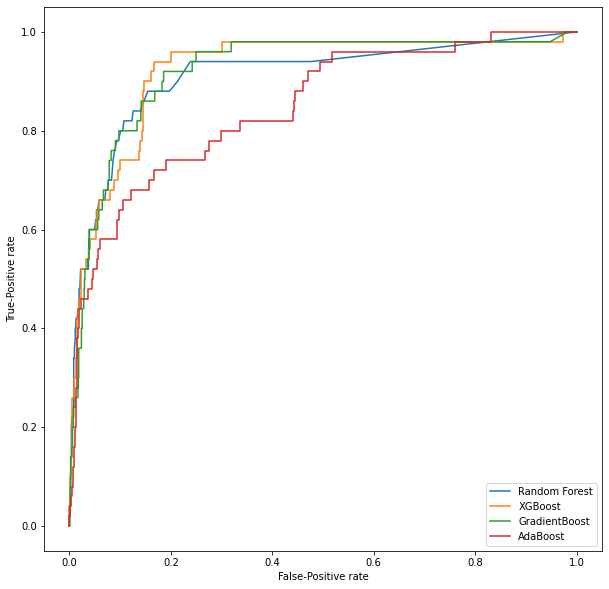

In [ ]:
# ROC curve of each algorithms
fig, ax = plt.subplots()
fig.set_size_inches(10,10)

for m in models:
    y_pred = models[m].predict_proba(XVALID)
    fpr, tpr, _ = roc_curve(YVALID, y_pred[:,1].ravel())
    plt.plot(fpr,tpr, label=m)
plt.xlabel('False-Positive rate')
plt.ylabel('True-Positive rate')
plt.legend()
plt.show()

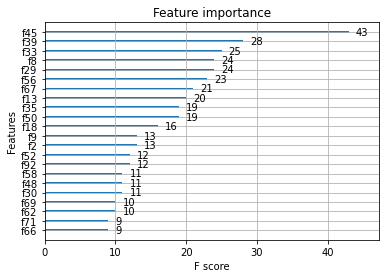

In [ ]:
# Plotting features importance of XGBoost
plot_importance(models['XGBoost'],max_num_features = 22)